In [ ]:
from google.cloud import bigquery as bq

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
conn = bq.Client.from_service_account_json("case.json")

# DAU
### What is DAU?

**DAU (Daily Active Users)** refers to the number of unique users who interact with an application or platform on a given day. It is a key performance metric used to measure user engagement and product stickiness.

---

### Why is DAU important?

- **Engagement Insight**: Shows how many users find the product valuable enough to return daily.
- **Growth Tracking**: Helps identify trends in user growth or decline.
- **Segmentation Analysis**: When broken down by dimensions (e.g., platform, country, ad network), it reveals which user segments are most active.
- **Decision Making**: Used by product, marketing, and executive teams to evaluate the success of updates, campaigns, or strategies.

---

### How is DAU calculated?

DAU is calculated by **counting distinct user IDs** that trigger events (such as sessions or interactions) within a 24-hour period. Additional segmentations (e.g., by platform, country, or ad network) can be applied to gain deeper insights.

---


In [ ]:
query_dau_1 = """
-- Calculate the Daily Active Users (DAU) by date
-- Measures user engagement by counting unique users per day

SELECT
  DATE(event_time) AS event_date,              -- Extract the date from timestamp
  COUNT(DISTINCT user_id) AS dau               -- Count of unique users (DAU) per day
FROM case_db.q1_table_session
GROUP BY event_date
ORDER BY event_date;

"""

In [ ]:
 df_dau_1 = conn.query(query_dau_1).to_dataframe()

In [ ]:
df_dau_1

,event_date,dau
0,2021-04-30,217
1,2021-05-01,9877
2,2021-05-02,14555
3,2021-05-03,15823
4,2021-05-04,18403
5,2021-05-05,21663
6,2021-05-06,22166
7,2021-05-07,24929
8,2021-05-08,28632
9,2021-05-09,32169


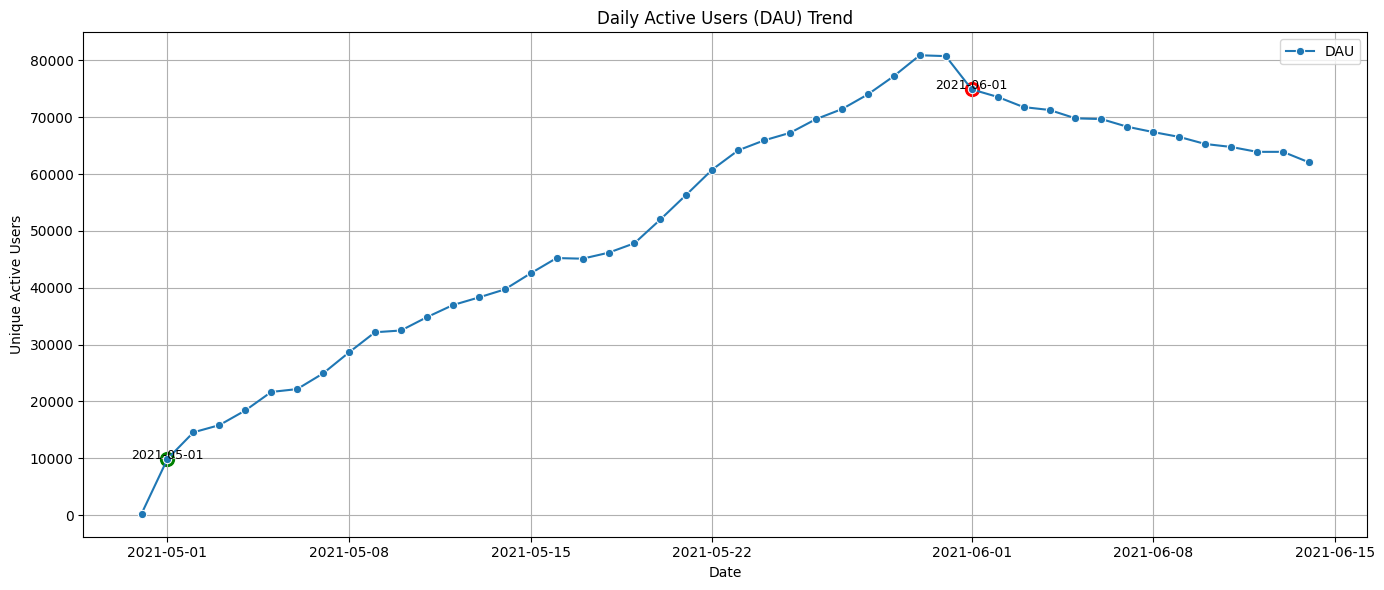

In [ ]:
# Plot DAU trend and highlight statistical outliers based on change (z-score) in DAU day-over-day

plt.figure(figsize=(14, 6))
# Plot daily DAU with a line and markers
sns.lineplot(data=df_dau_1, x="event_date", y="dau", marker="o", label="DAU")
# Calculate day-over-day difference in DAU
df_dau_1["dau_diff"] = df_dau_1["dau"].diff()
# Calculate z-scores for DAU change to identify significant deviations (spikes or drops)
df_dau_1["z_score"] = (df_dau_1["dau_diff"] - df_dau_1["dau_diff"].mean()) / df_dau_1["dau_diff"].std()
# Define a threshold for identifying statistical anomalies
threshold = 2
spikes = df_dau_1[np.abs(df_dau_1["z_score"]) > threshold]

# Highlight spikes with scatter points and labels (green = positive spike, red = drop)
for i, row in spikes.iterrows():
    plt.scatter(row["event_date"], row["dau"],
                color="green" if row["z_score"] > 0 else "red",
                s=100)
    plt.text(row["event_date"], row["dau"] + 20,
             f"{row['event_date'].strftime('%Y-%m-%d')}",
             ha='center', fontsize=9, color="black")

plt.title("Daily Active Users (DAU) Trend")
plt.xlabel("Date")
plt.ylabel("Unique Active Users")
plt.grid(True)
plt.tight_layout()
plt.show()

## DAU Trend Summary

- DAU increased steadily throughout May, indicating strong user growth.
- Peak activity occurred at the end of May with ~80,000 users.
- A sharp drop was observed on 2021-06-01, followed by a gradual decline.
- Anomaly detection highlighted significant spikes and dips, suggesting possible campaign effects or system changes.


In [ ]:
query_dau_2 = """
-- Calculate Daily Active Users (DAU) per platform
-- Standardizes platform values and groups unique user counts by day and platform

WITH all_events AS (
  SELECT
    DATE(event_time) AS event_date,
    user_id,
    CASE
      WHEN LOWER(platform) = 'andrgid' THEN 'android'                   -- Corrects common typo
      WHEN platform IS NULL OR TRIM(platform) = '' THEN 'unknown'       -- Handles missing or blank platform values
      ELSE LOWER(platform)
    END AS platform
  FROM case_db.q1_table_session
)

SELECT
  event_date,
  platform,
  COUNT(DISTINCT user_id) AS dau     -- Count of unique active users per day per platform
FROM all_events
GROUP BY event_date, platform
ORDER BY event_date, platform;
"""

In [ ]:
 df_dau_2 = conn.query(query_dau_2).to_dataframe()

In [ ]:
df_dau_2

,event_date,platform,dau
0,2021-04-30,android,60
1,2021-04-30,ios,157
2,2021-05-01,android,3812
3,2021-05-01,ios,6066
4,2021-05-02,android,5634
...,...,...,...
94,2021-06-12,ios,35937
95,2021-06-13,android,27987
96,2021-06-13,ios,35954
97,2021-06-14,android,27150


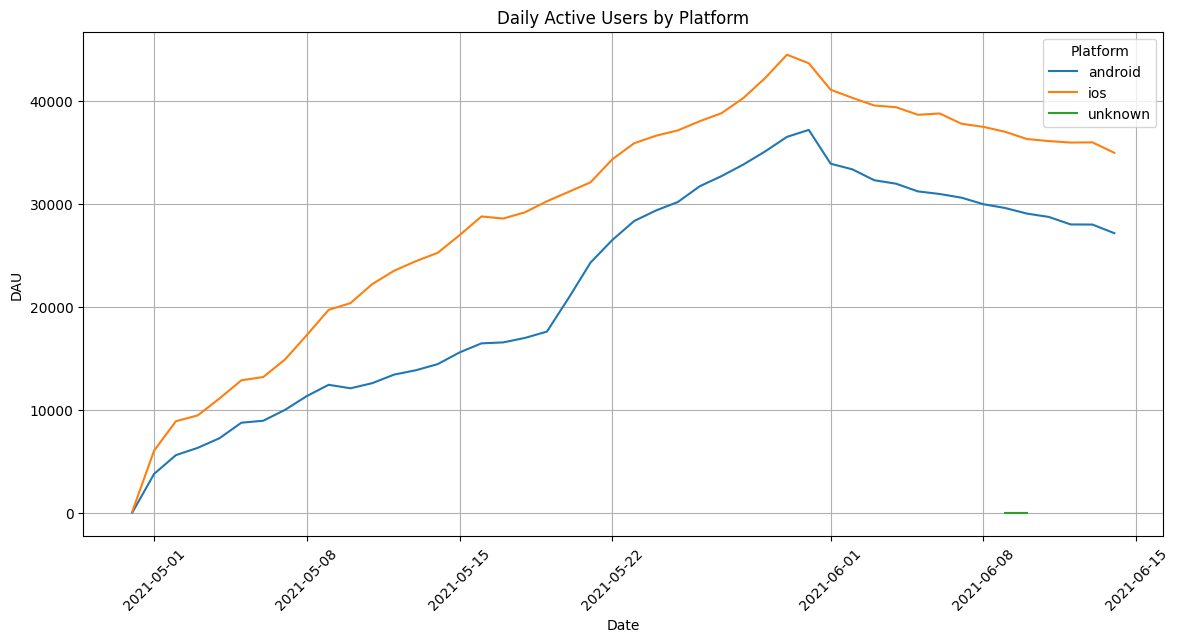

In [ ]:
# Pivot the DataFrame to prepare for multi-line plot by platform
pivot_df_dau_2 = df_dau_2.pivot(index='event_date', columns='platform', values='dau')

# Plot DAU trends by platform over time
plt.figure(figsize=(12, 6))
for platform in pivot_df_dau_2.columns:
    plt.plot(pivot_df_dau_2.index, pivot_df_dau_2[platform], label=platform)

plt.title('Daily Active Users by Platform')
plt.xlabel('Date')
plt.ylabel('DAU')
plt.legend(title='Platform')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

## DAU by Platform Summary

- iOS maintained higher DAU than Android throughout the period.
- Both platforms peaked in early June, followed by a decline.
- Android’s drop after peak was steeper than iOS.

In [ ]:
query_dau_3 = """
-- Calculate Daily Active Users (DAU) by country
-- Joins session data with install data to attribute each session to a country

WITH install_data AS (
  SELECT
    user_id,
    country
  FROM case_db.q1_table_install
),

events_with_country AS (
  SELECT
    DATE(s.event_time) AS event_date,
    s.user_id,
    COALESCE(i.country, 'unknown') AS country   -- Assign 'unknown' if country info is missing
  FROM case_db.q1_table_session s
  LEFT JOIN install_data i
    ON s.user_id = i.user_id
)

SELECT
  event_date,
  country,
  COUNT(DISTINCT user_id) AS dau                 -- Daily unique users per country
FROM events_with_country
GROUP BY event_date, country
ORDER BY event_date, country;

"""

In [ ]:
 df_dau_3 = conn.query(query_dau_3).to_dataframe()

In [ ]:
df_dau_3

,event_date,country,dau
0,2021-04-30,Mercury,80
1,2021-04-30,Pluton,41
2,2021-04-30,Uranus,2
3,2021-04-30,Venus,94
4,2021-05-01,Mercury,4659
...,...,...,...
224,2021-06-14,Mercury,25588
225,2021-06-14,Pluton,19090
226,2021-06-14,Saturn,2121
227,2021-06-14,Uranus,1252


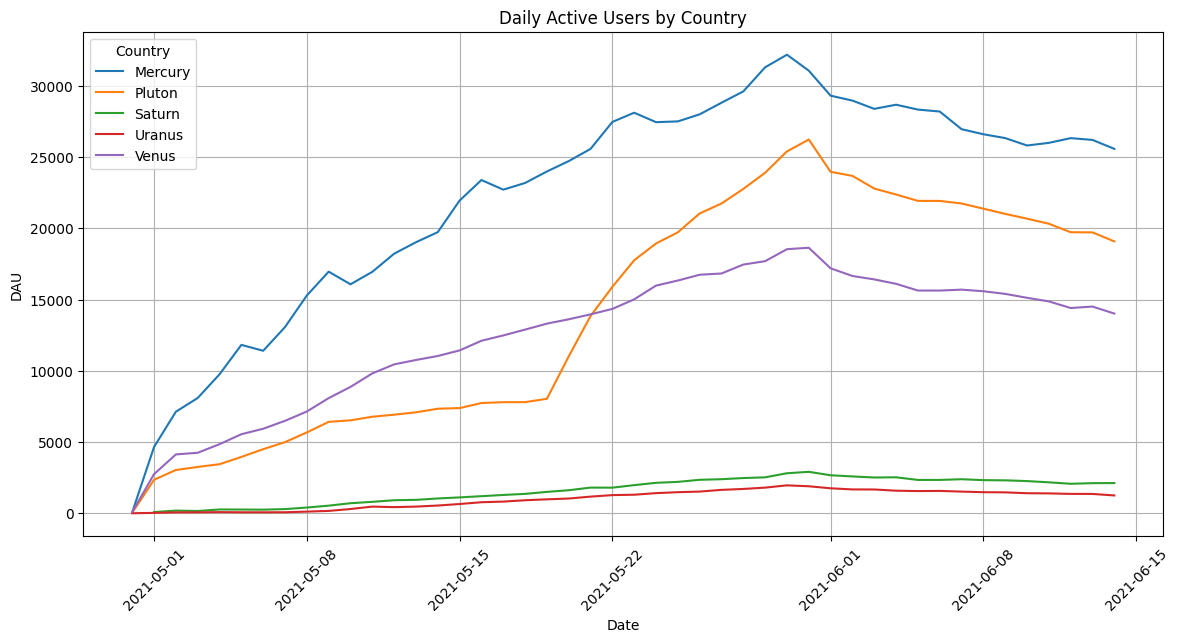

In [ ]:
# Pivot data to plot DAU per country over time
pivot_df_dau_3 = df_dau_3.pivot(index='event_date', columns='country', values='dau')

plt.figure(figsize=(12, 6))
for country in pivot_df_dau_3.columns:
    plt.plot(pivot_df_dau_3.index, pivot_df_dau_3[country], label=country)

plt.title('Daily Active Users by Country')
plt.xlabel('Date')
plt.ylabel('DAU')
plt.legend(title='Country')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


## DAU by Country Summary

- Mercury had the highest DAU overall and peaked around end of May.
- Pluton showed strong growth in late May but dropped sharply after its peak.
- Venus showed consistent mid-level activity with a gradual decline after June.
- Saturn and Uranus had minimal user activity compared to other countries.


In [ ]:
query_dau_4 = """
-- Calculate Daily Active Users (DAU) by ad network
-- Matches session data with install network information

WITH install_data AS (
  SELECT
    user_id,
    network
  FROM case_db.q1_table_install
),

events_with_network AS (
  SELECT
    DATE(s.event_time) AS event_date,
    s.user_id,
    COALESCE(i.network, 'unknown') AS network    -- Assign 'unknown' if network is missing
  FROM case_db.q1_table_session s
  LEFT JOIN install_data i
    ON s.user_id = i.user_id
)

SELECT
  event_date,
  network,
  COUNT(DISTINCT user_id) AS dau                 -- Daily unique users attributed to each network
FROM events_with_network
GROUP BY event_date, network
ORDER BY event_date, network;

"""

In [ ]:
 df_dau_4 = conn.query(query_dau_4).to_dataframe()

In [ ]:
df_dau_4

,event_date,network,dau
0,2021-04-30,Buzz,132
1,2021-04-30,Jessie,6
2,2021-04-30,Organic,41
3,2021-04-30,Sid,10
4,2021-04-30,Woody,28
...,...,...,...
225,2021-06-14,Buzz,37115
226,2021-06-14,Jessie,740
227,2021-06-14,Organic,16428
228,2021-06-14,Sid,2302


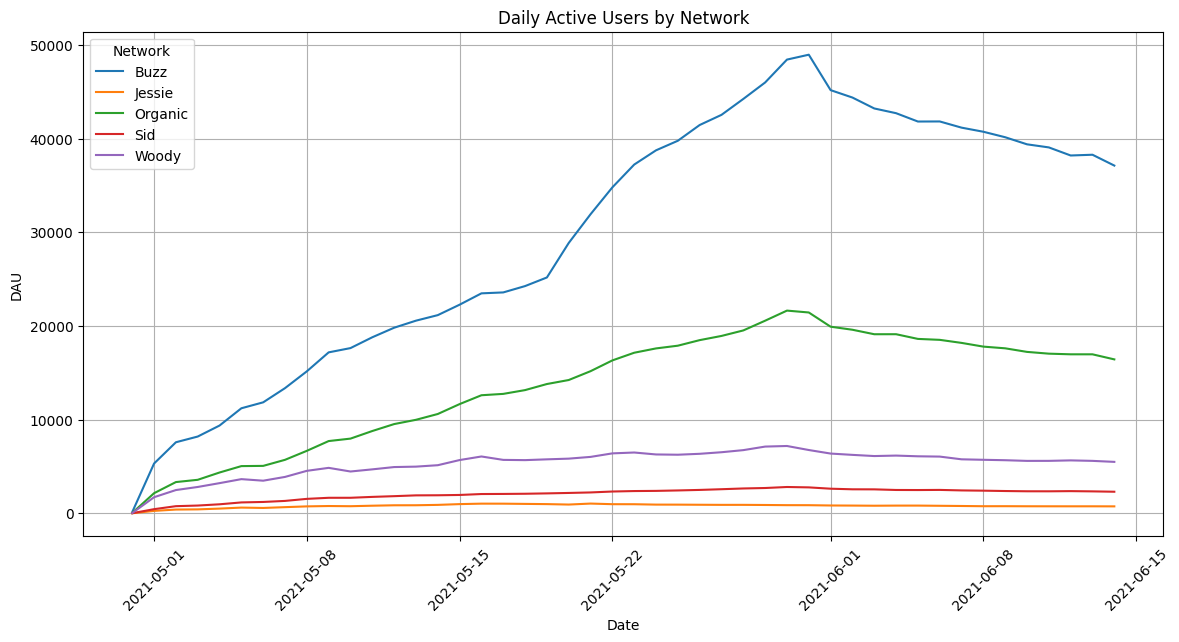

In [ ]:
# Pivot data to create a time series of DAU per network
pivot_df_dau_4 = df_dau_4.pivot(index='event_date', columns='network', values='dau')

# Plot the DAU trend per network
plt.figure(figsize=(12, 6))
for network in pivot_df_dau_4.columns:
    plt.plot(pivot_df_dau_4.index, pivot_df_dau_4[network], label=network)

plt.title('Daily Active Users by Network')
plt.xlabel('Date')
plt.ylabel('DAU')
plt.legend(title='Network')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

## DAU by Network Summary

- Buzz drove the highest DAU, peaking near 49,000 before a gradual decline.
- Organic growth was strong and sustained, second only to Buzz.
- Woody showed consistent but moderate activity.
- Jessie and Sid had minimal impact on DAU throughout the period.
- All networks peaked around late May to early June, then declined slightly.


#ARPU

### What is ARPU?

**ARPU (Average Revenue Per User)** measures the average revenue generated by each user over a specific time period. In mobile analytics, a common variation is **7-day ARPU**, which looks at revenue earned within 7 days of a user's install.

---

### Why is ARPU important?

- **Monetization Insight**: Reveals how effectively the product converts users into revenue.
- **User Quality Evaluation**: Helps distinguish high-value user segments (e.g., by country, platform, or network).
- **Marketing Optimization**: Enables smarter allocation of user acquisition budget based on return potential.
- **Revenue Forecasting**: Provides a base for projecting long-term value and setting business goals.

---

### How is ARPU calculated?

ARPU is calculated as:
ARPU = Total Revenue / Number of Users
For **7-day ARPU**, it considers only the revenue each user generates within 7 days of their install date.


In [ ]:
query_arpu_1 = """
-- Calculate 7-day ARPU (Average Revenue Per User) from install date

WITH install_data AS (
  SELECT
    user_id,
    DATE(event_time) AS install_date
  FROM case_db.q1_table_install
),

revenue_7d AS (
  SELECT
    r.user_id,
    CAST(r.revenue AS FLOAT64) AS revenue,
    DATE(r.event_time) AS revenue_date
  FROM case_db.q1_table_revenue r
  JOIN install_data i
    ON r.user_id = i.user_id
  WHERE DATE(r.event_time) BETWEEN i.install_date AND DATE_ADD(i.install_date, INTERVAL 7 DAY) -- Revenue within 7 days
)

SELECT
  COUNT(DISTINCT i.user_id) AS total_users,  -- Total number of users
  SUM(CAST(r.revenue AS FLOAT64)) AS total_revenue,  -- Total revenue generated within 7 days post-install
  SAFE_DIVIDE(SUM(CAST(r.revenue AS FLOAT64)), COUNT(DISTINCT i.user_id)) AS arpu_7d  -- 7-day ARPU
FROM install_data i
LEFT JOIN revenue_7d r
  ON i.user_id = r.user_id;

"""

In [ ]:
 df_arpu_1 = conn.query(query_arpu_1).to_dataframe()

In [ ]:
df_arpu_1

,total_users,total_revenue,arpu_7d
0,215082,132280.0,0.615021


## 7-Day ARPU Summary

- A total of **215,082** users were acquired.
- These users generated approximately **132,280** in revenue within 7 days of install.
- The calculated **7-day ARPU** is **0.615**, indicating moderate early monetization per user.

In [ ]:
query_arpu_2 = """
-- Calculate 7-day ARPU (Average Revenue Per User) per country after user installation.

WITH install_data AS (
  SELECT
    user_id,
    DATE(event_time) AS install_date,
    country
  FROM case_db.q1_table_install
),

revenue_7d AS (
  -- Filter revenues within 7 days of install
  SELECT
    r.user_id,
    CAST(r.revenue AS FLOAT64) AS revenue,
    DATE(r.event_time) AS revenue_date
  FROM case_db.q1_table_revenue r
  JOIN install_data i
    ON r.user_id = i.user_id
  WHERE DATE(r.event_time) BETWEEN i.install_date AND DATE_ADD(i.install_date, INTERVAL 7 DAY)
)

-- Aggregate total users, total revenue, and compute 7-day ARPU by country
SELECT
  i.country,
  COUNT(DISTINCT i.user_id) AS total_users,
  SUM(CAST(r.revenue AS FLOAT64)) AS total_revenue,
  SAFE_DIVIDE(SUM(CAST(r.revenue AS FLOAT64)), COUNT(DISTINCT i.user_id)) AS arpu_7d
FROM install_data i
LEFT JOIN revenue_7d r
  ON i.user_id = r.user_id
GROUP BY i.country
ORDER BY arpu_7d DESC;

"""

In [ ]:
 df_arpu_2 = conn.query(query_arpu_2).to_dataframe()

In [ ]:
df_arpu_2

,country,total_users,total_revenue,arpu_7d
0,Mercury,87198,74630.0,0.855868
1,Venus,56136,45754.0,0.815056
2,Uranus,4957,894.0,0.180351
3,Pluton,59513,10128.0,0.170181
4,Saturn,7278,874.0,0.120088


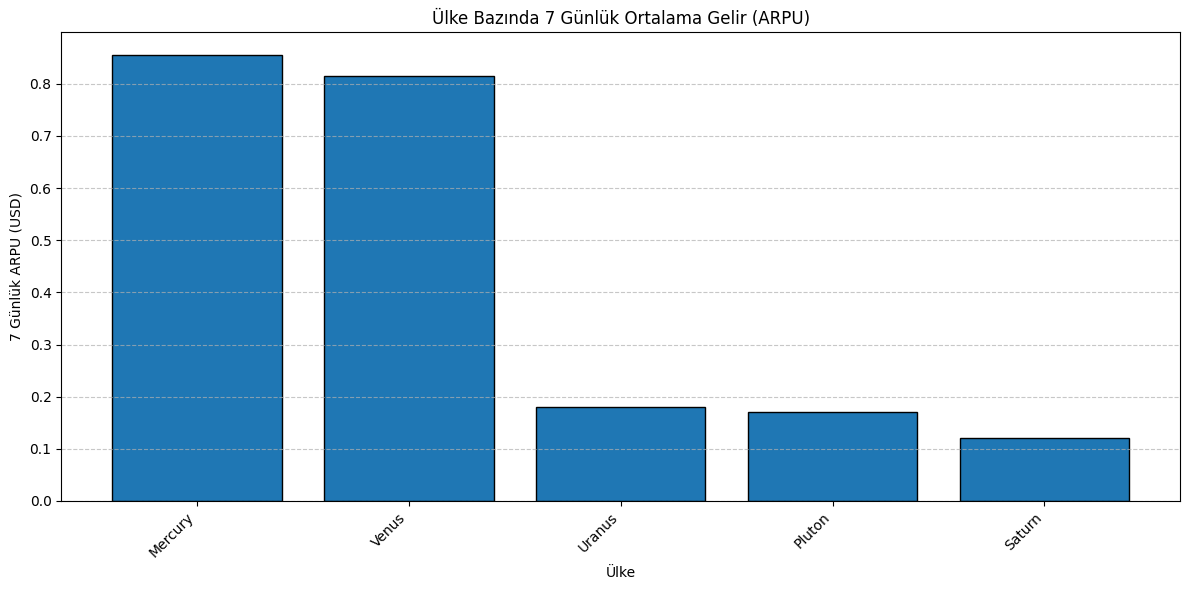

In [ ]:
# Plot 7-day ARPU by country as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_arpu_2['country'], df_arpu_2['arpu_7d'], edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.ylabel("7 Günlük ARPU (USD)")
plt.xlabel("Ülke")
plt.title("Ülke Bazında 7 Günlük Ortalama Gelir (ARPU)")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 7-Day ARPU by Country - Key Insights

- **Mercury** and **Venus** show significantly higher 7-day ARPU (above $0.80), indicating more monetizable users.
- **Uranus**, **Pluton**, and **Saturn** have much lower ARPU, suggesting limited early revenue potential from these regions.
- Focusing marketing or feature investments in Mercury and Venus may yield better ROI in short-term revenue.



In [ ]:
query_arpu_3 = """
-- Computes 7-day ARPU (Average Revenue Per User) segmented by platform
WITH install_data AS (
  SELECT
    user_id,
    DATE(event_time) AS install_date,
    platform
  FROM case_db.q1_table_install
),

-- Filters revenues that occurred within 7 days after each user's install date
revenue_7d AS (
  SELECT
    r.user_id,
    CAST(r.revenue AS FLOAT64) AS revenue,
    DATE(r.event_time) AS revenue_date
  FROM case_db.q1_table_revenue r
  JOIN install_data i
    ON r.user_id = i.user_id
  WHERE DATE(r.event_time) BETWEEN i.install_date AND DATE_ADD(i.install_date, INTERVAL 7 DAY)
)

-- Aggregates revenue and user counts to compute ARPU by platform
SELECT
  i.platform,
  COUNT(DISTINCT i.user_id) AS total_users,
  SUM(CAST(r.revenue AS FLOAT64)) AS total_revenue,
  SAFE_DIVIDE(SUM(CAST(r.revenue AS FLOAT64)), COUNT(DISTINCT i.user_id)) AS arpu_7d
FROM install_data i
LEFT JOIN revenue_7d r
  ON i.user_id = r.user_id
GROUP BY i.platform
ORDER BY arpu_7d DESC;

"""

In [ ]:
 df_arpu_3 = conn.query(query_arpu_3).to_dataframe()

In [ ]:
df_arpu_3

,platform,total_users,total_revenue,arpu_7d
0,ios,113106,100056.0,0.884622
1,android,101976,32224.0,0.315996


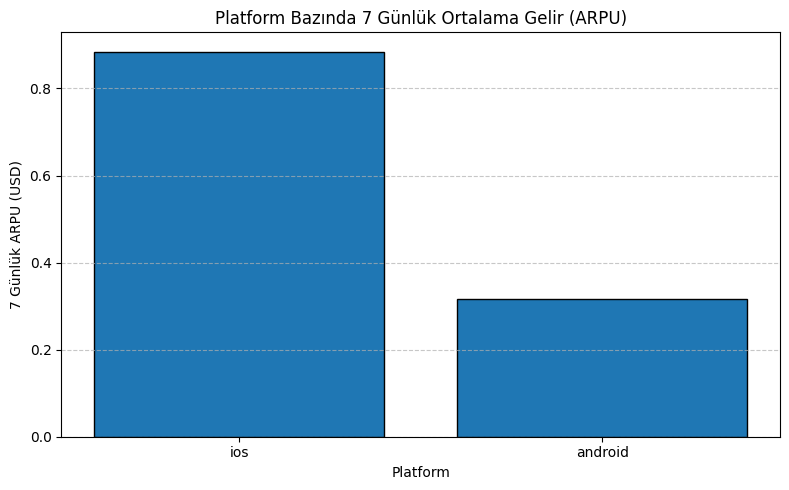

In [ ]:
# Bar chart of 7-day ARPU by platform
df_arpu_3 = df_arpu_3.sort_values('arpu_7d', ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(df_arpu_3['platform'], df_arpu_3['arpu_7d'], edgecolor='black')
plt.ylabel("7 Days ARPU (USD)")
plt.xlabel("Platform")
plt.title("Platform Based 7 Days ARPU")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 7-Day ARPU by Platform - Key Insights

- **iOS users generate nearly 3x more revenue** than Android users within the first 7 days post-install.
- This suggests stronger monetization behavior or higher purchasing power among iOS users.
- Marketing or product strategies targeting iOS could potentially yield higher early-stage returns.


In [ ]:
query_arpu_4 = """
-- Calculates 7-day ARPU segmented by acquisition network
WITH install_data AS (
  SELECT
    user_id,
    DATE(event_time) AS install_date,
    network
  FROM case_db.q1_table_install
),

-- Filters revenues to include only those within 7 days of user install
revenue_7d AS (
  SELECT
    r.user_id,
    CAST(r.revenue AS FLOAT64) AS revenue,
    DATE(r.event_time) AS revenue_date
  FROM case_db.q1_table_revenue r
  JOIN install_data i
    ON r.user_id = i.user_id
  WHERE DATE(r.event_time) BETWEEN i.install_date AND DATE_ADD(i.install_date, INTERVAL 7 DAY)
)

-- Aggregates ARPU per network
SELECT
  i.network,
  COUNT(DISTINCT i.user_id) AS total_users,
  SUM(CAST(r.revenue AS FLOAT64)) AS total_revenue,
  SAFE_DIVIDE(SUM(CAST(r.revenue AS FLOAT64)), COUNT(DISTINCT i.user_id)) AS arpu_7d
FROM install_data i
LEFT JOIN revenue_7d r
  ON i.user_id = r.user_id
GROUP BY i.network
ORDER BY arpu_7d DESC;

"""

In [ ]:
 df_arpu_4 = conn.query(query_arpu_4).to_dataframe()

In [ ]:
df_arpu_4

,network,total_users,total_revenue,arpu_7d
0,Sid,7109,11992.0,1.686876
1,Buzz,122093,72390.0,0.592909
2,Organic,58440,33931.0,0.580613
3,Jessie,2790,1525.0,0.546595
4,Woody,24650,12442.0,0.504746


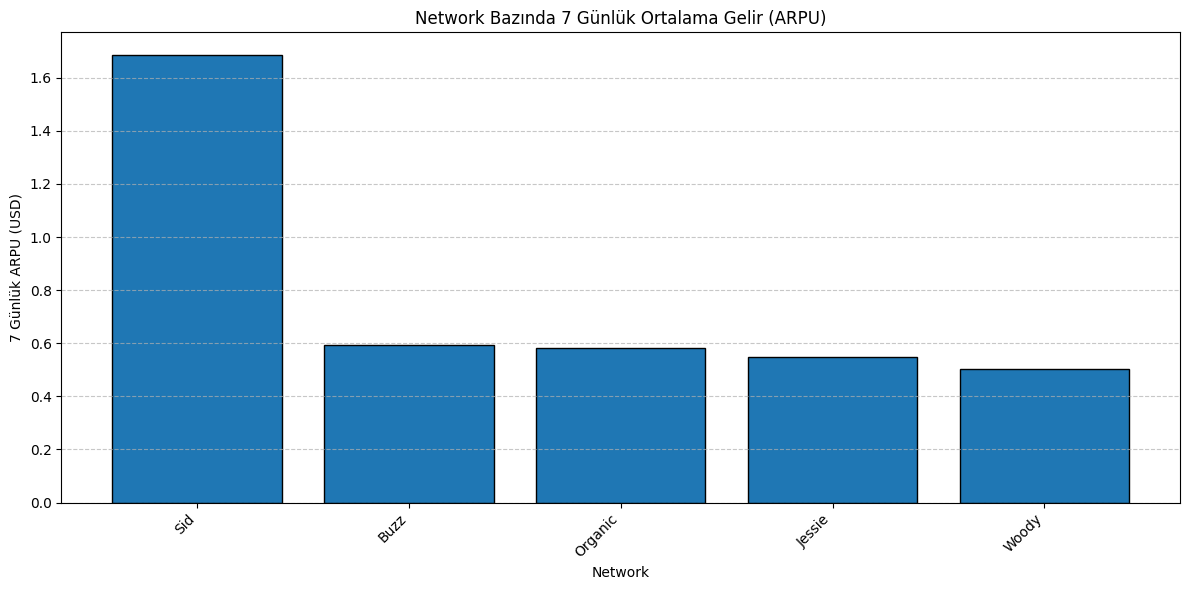

In [ ]:
# Bar chart of 7-day ARPU by network
df_arpu_4 = df_arpu_4.sort_values('arpu_7d', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(df_arpu_4['network'], df_arpu_4['arpu_7d'], edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.ylabel("7 Günlük ARPU (USD)")
plt.xlabel("Network")
plt.title("Network Bazında 7 Günlük Ortalama Gelir (ARPU)")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 7-Day ARPU by Network - Summary

- **Sid network significantly outperforms all others** with the highest ARPU, nearly 3x above the rest.
- Buzz, Organic, Jessie, and Woody networks have similar and much lower revenue performance.
- Optimizing acquisition through Sid may yield better early monetization.

#ARPDAU

### What is ARPDAU?

**ARPDAU (Average Revenue Per Daily Active User)** measures the average revenue generated from each active user on a given day. It combines monetization and engagement metrics to reflect daily revenue efficiency.

---

### Why is ARPDAU important?

- **Revenue Efficiency**: Indicates how much revenue each active user brings in per day.
- **Monetization Performance**: Helps evaluate the impact of ads, in-app purchases, and premium features.
- **Segmented Insights**: When broken down by platform, country, or network, it identifies where revenue per user is strongest.
- **Growth Strategy**: Aids in making informed decisions on pricing, user acquisition, and retention efforts.

---

### How is ARPDAU calculated?

ARPDAU is computed by dividing the **total revenue generated on a specific day** by the **number of daily active users (DAU)** on that same day:
ARPDAU = Total Revenue on a Day / DAU on the Same Day

This metric can be segmented by platform, country, or acquisition network to enhance business insights.

---


In [ ]:
query_arpdau_1 = """
-- Calculates daily ARPDAU (Average Revenue Per Daily Active User)
WITH revenue_per_day AS (
  SELECT
    DATE(event_time) AS event_date,
    SUM(CAST(revenue AS FLOAT64)) AS total_revenue
  FROM case_db.q1_table_revenue
  GROUP BY event_date
),

dau_per_day AS (
  SELECT
    DATE(event_time) AS event_date,
    COUNT(DISTINCT user_id) AS dau
  FROM case_db.q1_table_session
  GROUP BY event_date
)

-- Combines daily revenue and DAU to compute ARPDAU
SELECT
  r.event_date,
  r.total_revenue,
  d.dau,
  SAFE_DIVIDE(r.total_revenue, d.dau) AS arpdau
FROM revenue_per_day r
JOIN dau_per_day d
  ON r.event_date = d.event_date
ORDER BY r.event_date;
"""

In [ ]:
 df_arpdau_1 = conn.query(query_arpdau_1).to_dataframe()

In [ ]:
df_arpdau_1.head()

,event_date,total_revenue,dau,arpdau
0,2021-04-30,2.0,217,0.009217
1,2021-05-01,313.0,9877,0.031690
2,2021-05-02,1418.0,14555,0.097424
3,2021-05-03,1871.0,15823,0.118246
4,2021-05-04,3003.0,18403,0.163180


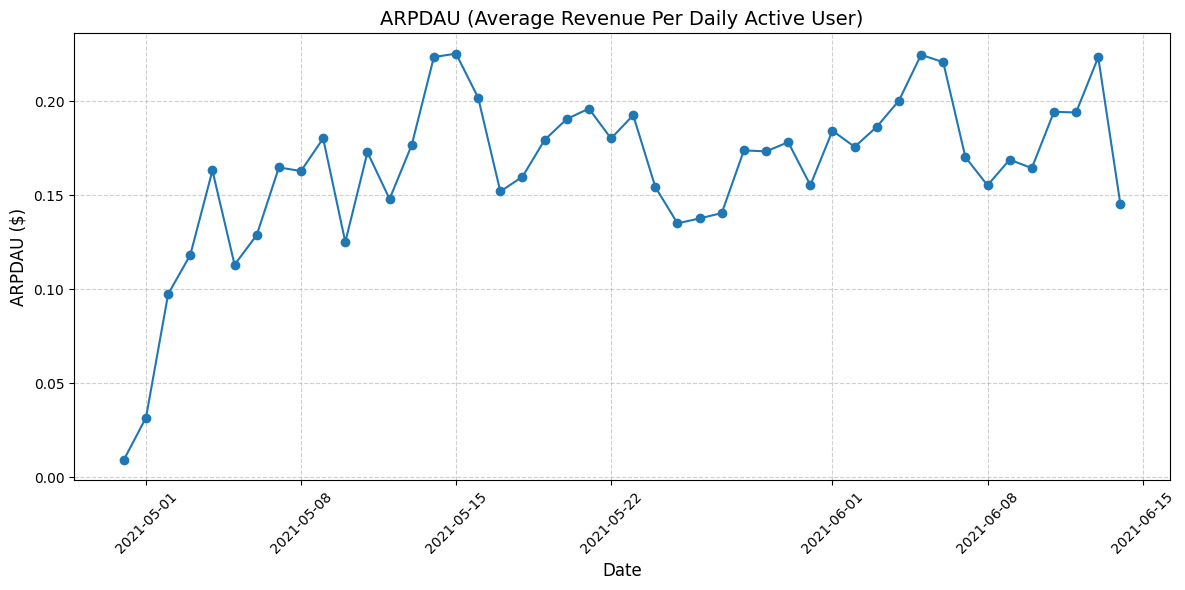

In [ ]:
# Plot ARPDAU over time
plt.figure(figsize=(12, 6))
plt.plot(df_arpdau_1['event_date'], df_arpdau_1['arpdau'], marker='o', linestyle='-')

plt.title('ARPDAU (Average Revenue Per Daily Active User)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('ARPDAU ($)', fontsize=12)

plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## ARPDAU Trend - Summary

- ARPDAU shows variability over time, peaking mid-May and early June.
- Sustained ARPDAU above $0.15 indicates consistent monetization performance.
- Occasional dips may suggest issues in engagement or monetization strategy on specific dates.


In [ ]:
query_arpdau_2 = """
-- Calculates daily ARPDAU separately for iOS and Android platforms
WITH revenue_per_day AS (
  SELECT
    DATE(event_time) AS event_date,
    LOWER(platform) AS platform,
    SUM(CAST(revenue AS FLOAT64)) AS total_revenue
  FROM case_db.q1_table_revenue
  GROUP BY event_date, platform
),

dau_per_day AS (
  SELECT
    DATE(event_time) AS event_date,
    LOWER(platform) AS platform,
    COUNT(DISTINCT user_id) AS dau
  FROM case_db.q1_table_session
  GROUP BY event_date, platform
)

-- Joins revenue and DAU data to calculate platform-based ARPDAU
SELECT
  r.event_date,
  r.platform,
  r.total_revenue,
  d.dau,
  SAFE_DIVIDE(r.total_revenue, d.dau) AS arpdau
FROM revenue_per_day r
JOIN dau_per_day d
  ON r.event_date = d.event_date AND r.platform = d.platform
ORDER BY r.event_date, r.platform;

"""

In [ ]:
 df_arpdau_2 = conn.query(query_arpdau_2).to_dataframe()

In [ ]:
df_arpdau_2

,event_date,platform,total_revenue,dau,arpdau
0,2021-04-30,android,2.0,60,0.033333
1,2021-05-01,android,86.0,3812,0.022560
2,2021-05-01,ios,227.0,6066,0.037422
3,2021-05-02,android,178.0,5634,0.031594
4,2021-05-02,ios,1240.0,8922,0.138982
...,...,...,...,...,...
86,2021-06-12,ios,9558.0,35937,0.265965
87,2021-06-13,android,3286.0,27987,0.117412
88,2021-06-13,ios,10997.0,35954,0.305863
89,2021-06-14,android,2381.0,27150,0.087698


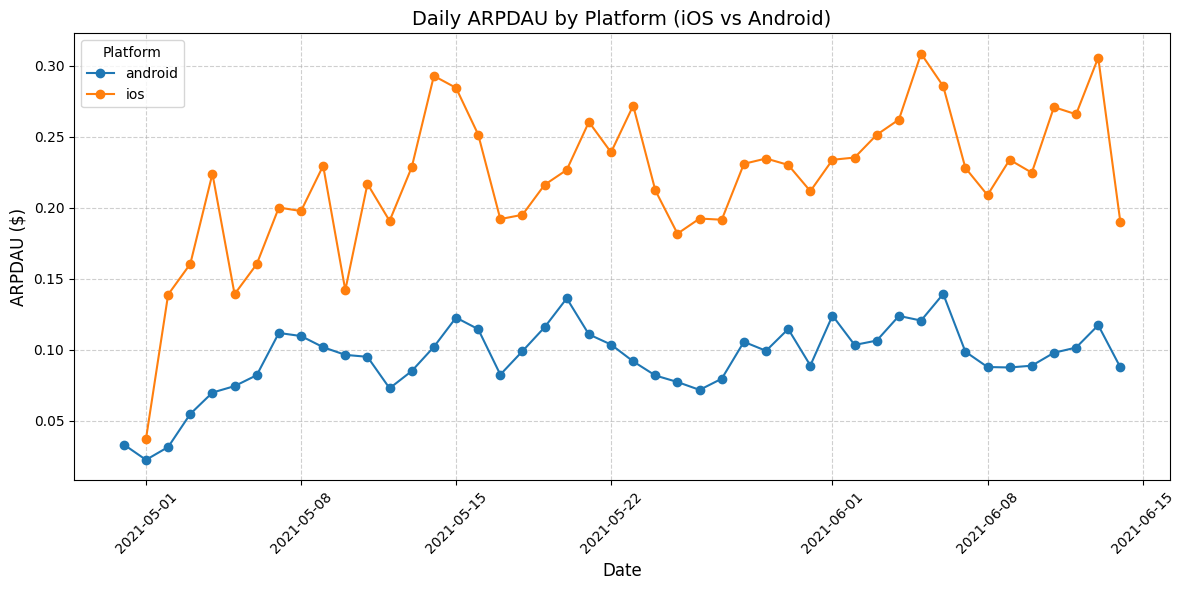

In [ ]:
# Plot ARPDAU trends for iOS and Android
pivot_df = df_arpdau_2.pivot(index='event_date', columns='platform', values='arpdau')

plt.figure(figsize=(12, 6))
for platform in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[platform], marker='o', label=platform)

plt.title('Daily ARPDAU by Platform (iOS vs Android)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('ARPDAU ($)', fontsize=12)
plt.legend(title='Platform')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## ARPDAU by Platform (iOS vs Android) - Summary

- iOS consistently shows higher ARPDAU than Android.
- This indicates iOS users generate significantly more revenue per daily active user.
- Monetization strategies may need platform-specific optimization, especially for Android.


In [ ]:
query_arpdau_3 = """
-- Calculates daily ARPDAU (Average Revenue Per Daily Active User) segmented by country
WITH install_data AS (
  SELECT user_id, country FROM case_db.q1_table_install
),

-- Aggregate total revenue per day and country
revenue_per_day AS (
  SELECT
    DATE(r.event_time) AS event_date,
    i.country,
    SUM(CAST(r.revenue AS FLOAT64)) AS total_revenue
  FROM case_db.q1_table_revenue r
  JOIN install_data i ON r.user_id = i.user_id
  GROUP BY event_date, i.country
),

-- Aggregate DAU per day and country
dau_per_day AS (
  SELECT
    DATE(s.event_time) AS event_date,
    i.country,
    COUNT(DISTINCT s.user_id) AS dau
  FROM case_db.q1_table_session s
  JOIN install_data i ON s.user_id = i.user_id
  GROUP BY event_date, i.country
)

-- Final ARPDAU calculation by joining revenue and DAU tables
SELECT
  r.event_date,
  r.country,
  r.total_revenue,
  d.dau,
  SAFE_DIVIDE(r.total_revenue, d.dau) AS arpdau
FROM revenue_per_day r
JOIN dau_per_day d
  ON r.event_date = d.event_date AND r.country = d.country
ORDER BY r.event_date, r.country;

"""

In [ ]:
 df_arpdau_3 = conn.query(query_arpdau_3).to_dataframe()

In [ ]:
df_arpdau_3

,event_date,country,total_revenue,dau,arpdau
0,2021-04-30,Mercury,2.0,80,0.025000
1,2021-05-01,Mercury,126.0,4659,0.027044
2,2021-05-01,Pluton,18.0,2355,0.007643
3,2021-05-01,Venus,171.0,2751,0.062159
4,2021-05-02,Mercury,787.0,7134,0.110317
...,...,...,...,...,...
210,2021-06-14,Mercury,4976.0,25588,0.194466
211,2021-06-14,Pluton,835.0,19090,0.043740
212,2021-06-14,Saturn,60.0,2121,0.028289
213,2021-06-14,Uranus,61.0,1252,0.048722


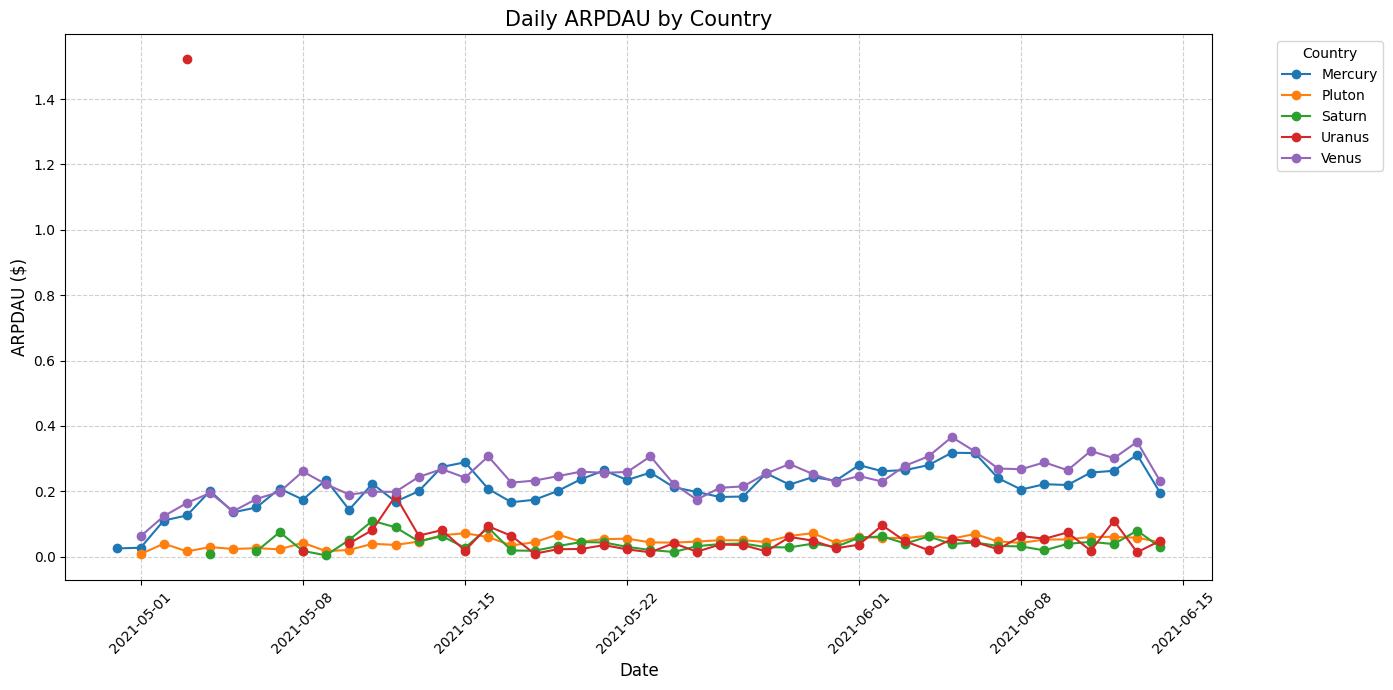

In [ ]:
# Plot daily ARPDAU trends by country
pivot_df = df_arpdau_3.pivot(index='event_date', columns='country', values='arpdau')

plt.figure(figsize=(14, 7))
for country in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[country], label=country, marker='o')

plt.title('Daily ARPDAU by Country', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('ARPDAU ($)', fontsize=12)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## ARPDAU by Country - Summary

- Venus and Mercury lead consistently with the highest ARPDAU across the entire period, indicating stronger monetization.
- Countries like Saturn, Uranus, and Pluton show significantly lower ARPDAU, suggesting lower revenue efficiency per user.
- One outlier spike is visible in Uranus; this may be due to a data anomaly or a one-time high spender.
- Variability in revenue per user across countries suggests need for localized monetization strategies.


In [ ]:
query_arpdau_4 = """
-- Calculates daily ARPDAU (Average Revenue Per Daily Active User) segmented by acquisition network
WITH install_data AS (
  SELECT user_id, network FROM case_db.q1_table_install
),

-- Aggregate total revenue per day and network
revenue_per_day AS (
  SELECT
    DATE(r.event_time) AS event_date,
    i.network,
    SUM(CAST(r.revenue AS FLOAT64)) AS total_revenue
  FROM case_db.q1_table_revenue r
  JOIN install_data i ON r.user_id = i.user_id
  GROUP BY event_date, i.network
),

-- Aggregate DAU per day and network
dau_per_day AS (
  SELECT
    DATE(s.event_time) AS event_date,
    i.network,
    COUNT(DISTINCT s.user_id) AS dau
  FROM case_db.q1_table_session s
  JOIN install_data i ON s.user_id = i.user_id
  GROUP BY event_date, i.network
)

-- Final ARPDAU calculation
SELECT
  r.event_date,
  r.network,
  r.total_revenue,
  d.dau,
  SAFE_DIVIDE(r.total_revenue, d.dau) AS arpdau
FROM revenue_per_day r
JOIN dau_per_day d
  ON r.event_date = d.event_date AND r.network = d.network
ORDER BY r.event_date, r.network;

"""

In [ ]:
 df_arpdau_4 = conn.query(query_arpdau_4).to_dataframe()

In [ ]:
df_arpdau_4

,event_date,network,total_revenue,dau,arpdau
0,2021-04-30,Buzz,2.0,132,0.015152
1,2021-05-01,Buzz,203.0,5315,0.038194
2,2021-05-01,Organic,42.0,2147,0.019562
3,2021-05-01,Sid,8.0,441,0.018141
4,2021-05-01,Woody,62.0,1718,0.036088
...,...,...,...,...,...
220,2021-06-14,Buzz,5179.0,37115,0.139539
221,2021-06-14,Jessie,26.0,740,0.035135
222,2021-06-14,Organic,2381.0,16428,0.144935
223,2021-06-14,Sid,818.0,2302,0.355343


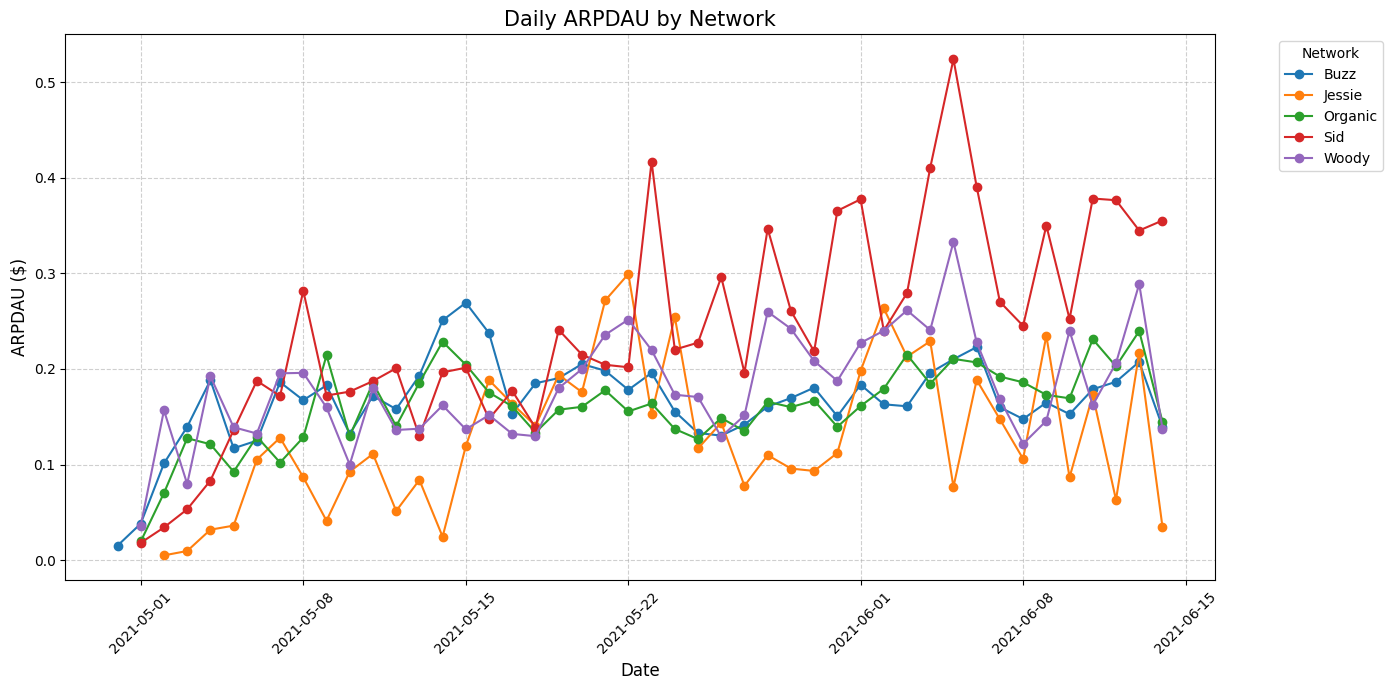

In [ ]:
# Plot daily ARPDAU trends by acquisition network
pivot_df = df_arpdau_4.pivot(index='event_date', columns='network', values='arpdau')

plt.figure(figsize=(14, 7))
for network in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[network], label=network, marker='o')

plt.title('Daily ARPDAU by Network', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('ARPDAU ($)', fontsize=12)
plt.legend(title='Network', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## ARPDAU by Network - Summary

- The **Sid** network has the highest ARPDAU values and shows multiple revenue spikes, indicating high monetization performance per user.
- **Jessie** consistently shows the lowest ARPDAU, suggesting weak revenue conversion.
- **Buzz, Organic, and Woody** maintain moderate and relatively stable ARPDAU trends throughout the period.
- Sid’s volatility implies campaigns or acquisition strategies with high short-term ROI, but possibly inconsistent user quality.


#ROAS

### What is ROAS?

**ROAS (Return on Ad Spend)** is a marketing metric that measures the revenue generated for every dollar spent on advertising. It shows the effectiveness of advertising campaigns in driving revenue.

---

### Why is ROAS important?

- **Performance Evaluation**: Indicates which campaigns, platforms, or markets generate positive returns.
- **Budget Optimization**: Helps reallocate spending toward high-performing channels and away from unprofitable ones.
- **Cross-Segment Insights**: When segmented by network, country, or platform, ROAS reveals which user acquisition strategies yield the best returns.
- **Strategic Planning**: Supports forecasting, campaign planning, and overall business growth decisions.

---

### How is ROAS calculated?

ROAS is calculated as:
ROAS = Total Revenue / Total Advertising Cost

It is often expressed as a **ratio** (e.g., 1.5) or a **percentage** (e.g., 150%). A ROAS greater than 1 (or 100%) means revenue exceeds ad cost, indicating a profitable campaign.

---

In [ ]:
query_roas_1 = """
-- Calculate ROAS (Return on Ad Spend) per network-country-platform by joining revenue and cost data

WITH revenue_by_channel AS (
  SELECT
    i.network,
    i.country,
    i.platform,
    SUM(CAST(r.revenue AS FLOAT64)) AS total_revenue
  FROM case_db.q1_table_revenue r
  JOIN case_db.q1_table_install i
    ON r.user_id = i.user_id
  GROUP BY i.network, i.country, i.platform
),

cost_by_channel AS (
  SELECT
    network,
    country,
    platform,
    SUM(cost) AS total_cost
  FROM case_db.q1_table_cost
  GROUP BY network, country, platform
)

SELECT
  r.network,
  r.country,
  r.platform,
  r.total_revenue,
  c.total_cost,
  SAFE_DIVIDE(r.total_revenue, c.total_cost) AS roas_ratio,
  SAFE_MULTIPLY(SAFE_DIVIDE(r.total_revenue, c.total_cost), 100) AS roas_percentage
FROM revenue_by_channel r
JOIN cost_by_channel c
  ON r.network = c.network
  AND r.country = c.country
  AND r.platform = c.platform
ORDER BY roas_ratio DESC;
"""

In [ ]:
 df_roas_1 = conn.query(query_roas_1).to_dataframe()

In [ ]:
df_roas_1

,network,country,platform,total_revenue,total_cost,roas_ratio,roas_percentage
0,Woody,Venus,ios,5049.0,2749.0,1.836668,183.666788
1,Sid,Venus,ios,19083.0,31290.0,0.609875,60.987536
2,Buzz,Pluton,ios,20082.0,34048.0,0.589814,58.981438
3,Buzz,Venus,ios,73967.0,140858.0,0.525117,52.511749
4,Buzz,Mercury,android,34459.0,88803.0,0.388039,38.803869
5,Jessie,Mercury,android,1936.0,5749.0,0.336754,33.675422
6,Buzz,Mercury,ios,83615.0,274456.0,0.304657,30.465721
7,Woody,Uranus,ios,20.0,84.0,0.238095,23.809524
8,Woody,Mercury,ios,24566.0,111943.0,0.219451,21.945097
9,Woody,Mercury,android,16268.0,75297.0,0.216051,21.605110


/tmp/ipython-input-272-731463347.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_roas_1, x='channel', y='roas_ratio', palette='Blues_d', edgecolor='black')


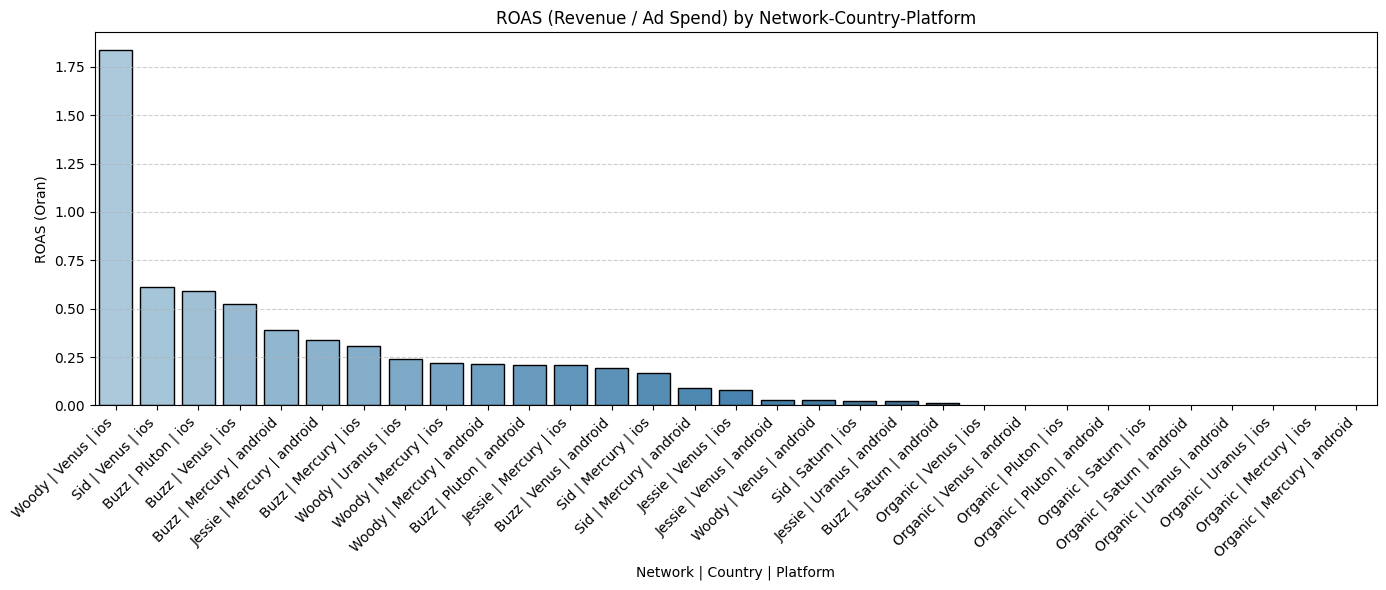

In [ ]:
# Combine network, country, and platform into a single label for visualization
df_roas_1['channel'] = df_roas_1['network'] + ' | ' + df_roas_1['country'] + ' | ' + df_roas_1['platform']
df_roas_1 = df_roas_1.sort_values('roas_ratio', ascending=False)

# Plot ROAS by channel
plt.figure(figsize=(14, 6))
sns.barplot(data=df_roas_1, x='channel', y='roas_ratio', palette='Blues_d', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.ylabel("ROAS (Oran)")
plt.xlabel("Network | Country | Platform")
plt.title("ROAS (Revenue / Ad Spend) by Network-Country-Platform")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### ROAS by Channel (Network-Country-Platform)

- **Top ROAS** observed in `Woody | Venus | iOS` (1.83), indicating a strong return on ad investment.
- Other high performers include `Sid | Venus | iOS` and `Buzz | Pluton | iOS`, all on iOS.
- iOS campaigns generally outperform Android in ROAS.

In [ ]:
query_roas_2 = """
-- Calculate ROAS (Return on Ad Spend) grouped by platform (iOS vs Android)

WITH revenue_by_platform AS (
  SELECT
    i.platform,
    SUM(CAST(r.revenue AS FLOAT64)) AS total_revenue
  FROM case_db.q1_table_revenue r
  JOIN case_db.q1_table_install i
    ON r.user_id = i.user_id
  GROUP BY i.platform
),

cost_by_platform AS (
  SELECT
    platform,
    SUM(cost) AS total_cost
  FROM case_db.q1_table_cost
  GROUP BY platform
)

SELECT
  r.platform,
  r.total_revenue,
  c.total_cost,
  SAFE_DIVIDE(r.total_revenue, c.total_cost) AS roas_ratio,
  SAFE_MULTIPLY(SAFE_DIVIDE(r.total_revenue, c.total_cost), 100) AS roas_percentage
FROM revenue_by_platform r
JOIN cost_by_platform c
  ON r.platform = c.platform
ORDER BY roas_ratio DESC;

"""

In [ ]:
 df_roas_2 = conn.query(query_roas_2).to_dataframe()

In [ ]:
df_roas_2

,platform,total_revenue,total_cost,roas_ratio,roas_percentage
0,ios,319154.0,640902.0,0.497976,49.797629
1,android,100973.0,309829.0,0.325899,32.589913


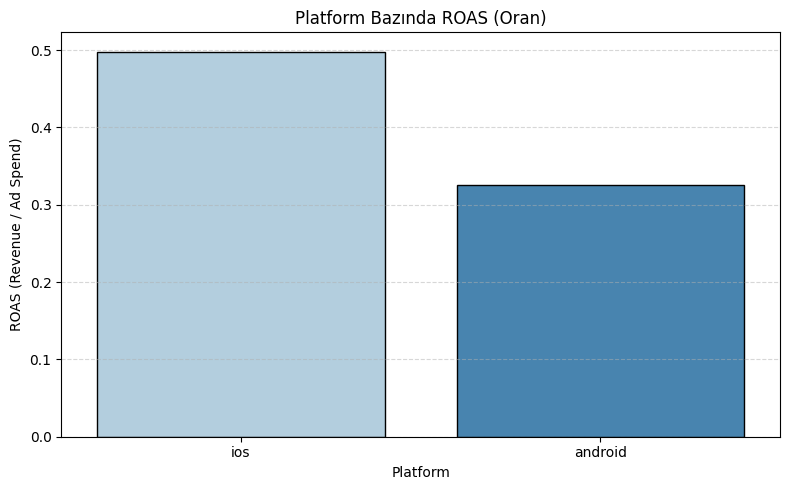

In [ ]:
# Visualize ROAS per platform

df_roas_2 = df_roas_2.sort_values('roas_ratio', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=df_roas_2, x='platform', y='roas_ratio', palette='Blues', edgecolor='black')
plt.title("Platform Bazında ROAS (Oran)")
plt.ylabel("ROAS (Revenue / Ad Spend)")
plt.xlabel("Platform")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### ROAS by Platform

- **iOS** has significantly higher ROAS (~0.50) compared to **Android** (~0.32).
- Indicates that iOS users yield better returns on advertising investments.
- Suggests allocating more marketing budget to iOS channels for higher efficiency.


In [ ]:
query_roas_3 = """
-- Calculate ROAS (Return on Ad Spend) grouped by country

WITH revenue_by_country AS (
  SELECT
    i.country,
    SUM(CAST(r.revenue AS FLOAT64)) AS total_revenue
  FROM case_db.q1_table_revenue r
  JOIN case_db.q1_table_install i
    ON r.user_id = i.user_id
  GROUP BY i.country
),

cost_by_country AS (
  SELECT
    country,
    SUM(cost) AS total_cost
  FROM case_db.q1_table_cost
  GROUP BY country
)

SELECT
  r.country,
  r.total_revenue,
  c.total_cost,
  SAFE_DIVIDE(r.total_revenue, c.total_cost) AS roas_ratio,
  SAFE_MULTIPLY(SAFE_DIVIDE(r.total_revenue, c.total_cost), 100) AS roas_percentage
FROM revenue_by_country r
JOIN cost_by_country c
  ON r.country = c.country
ORDER BY roas_ratio DESC;

"""

In [ ]:
 df_roas_3 = conn.query(query_roas_3).to_dataframe()

In [ ]:
df_roas_3

,country,total_revenue,total_cost,roas_ratio,roas_percentage
0,Uranus,2107.0,699.0,3.014306,301.430615
1,Saturn,2901.0,974.0,2.978439,297.843943
2,Pluton,33476.0,63558.0,0.526700,52.670002
3,Venus,145979.0,280072.0,0.521220,52.121954
4,Mercury,235664.0,605428.0,0.389252,38.925190


/tmp/ipython-input-280-200267274.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_roas_3, x='country', y='roas_ratio', palette='Greens', edgecolor='black')


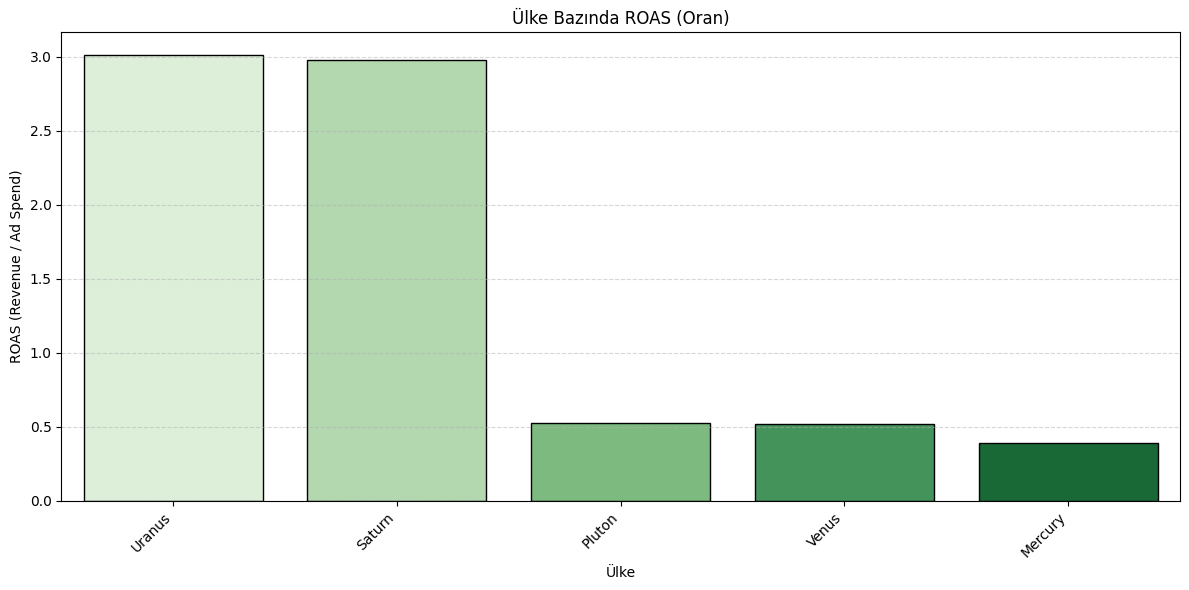

In [ ]:
# Visualize ROAS by country

df_roas_3 = df_roas_3.sort_values('roas_ratio', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_roas_3, x='country', y='roas_ratio', palette='Greens', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title("Ülke Bazında ROAS (Oran)")
plt.ylabel("ROAS (Revenue / Ad Spend)")
plt.xlabel("Ülke")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### ROAS by Country

- **Uranus** and **Saturn** have exceptionally high ROAS (~3.0), indicating outstanding marketing efficiency in those markets.
- Other countries such as **Pluton**, **Venus**, and **Mercury** show much lower ROAS (below 0.6).
- Investment in Uranus and Saturn is yielding the highest return and may warrant increased marketing focus.


In [ ]:
query_roas_4 = """
-- Calculate ROAS (Return on Ad Spend) grouped by ad network

WITH revenue_by_network AS (
  SELECT
    i.network,
    SUM(CAST(r.revenue AS FLOAT64)) AS total_revenue
  FROM case_db.q1_table_revenue r
  JOIN case_db.q1_table_install i
    ON r.user_id = i.user_id
  GROUP BY i.network
),

cost_by_network AS (
  SELECT
    network,
    SUM(cost) AS total_cost
  FROM case_db.q1_table_cost
  GROUP BY network
)

SELECT
  r.network,
  r.total_revenue,
  c.total_cost,
  SAFE_DIVIDE(r.total_revenue, c.total_cost) AS roas_ratio,
  SAFE_MULTIPLY(SAFE_DIVIDE(r.total_revenue, c.total_cost), 100) AS roas_percentage
FROM revenue_by_network r
JOIN cost_by_network c
  ON r.network = c.network
ORDER BY roas_ratio DESC;

"""

In [ ]:
 df_roas_4 = conn.query(query_roas_4).to_dataframe()

In [ ]:
df_roas_4

,network,total_revenue,total_cost,roas_ratio,roas_percentage
0,Sid,24619.0,67168.0,0.366529,36.652870
1,Buzz,238187.0,670052.0,0.355475,35.547540
2,Woody,45917.0,190834.0,0.240612,24.061226
3,Jessie,4942.0,22677.0,0.217930,21.793006
4,Organic,106462.0,0.0,NaN,NaN


/tmp/ipython-input-284-2452111325.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_roas_4, x='network', y='roas_ratio', palette='Purples', edgecolor='black')


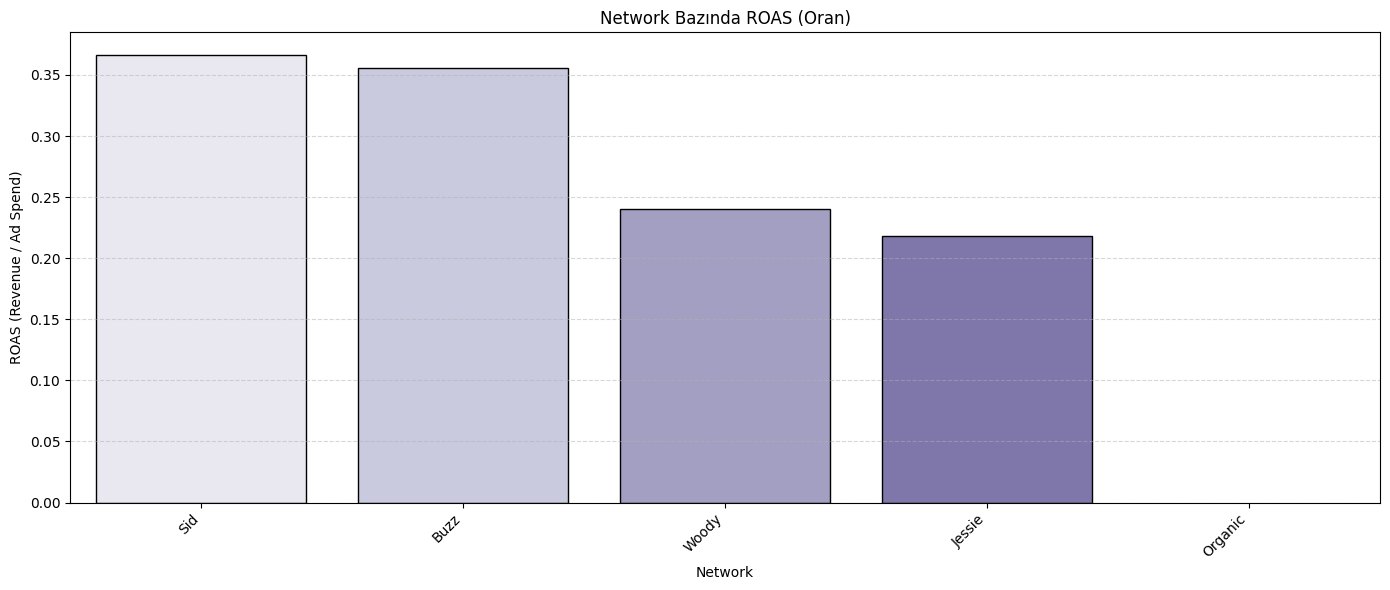

In [ ]:
# Visualize ROAS by ad network

df_roas_4 = df_roas_4.sort_values('roas_ratio', ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(data=df_roas_4, x='network', y='roas_ratio', palette='Purples', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title("Network Bazında ROAS (Oran)")
plt.ylabel("ROAS (Revenue / Ad Spend)")
plt.xlabel("Network")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### ROAS by Network

- **Sid** and **Buzz** networks delivered the highest ROAS values (above 0.35), indicating better cost-efficiency in driving revenue.
- **Woody** and **Jessie** followed with lower performance.
- Sid appears to be the most effective paid channel in terms of return on advertising.


#Retention

### What is Retention?

**Retention** measures how many users return to use an app after their initial interaction (usually install). Common retention checkpoints include **Day 1**, **Day 3**, and **Day 7**, indicating engagement strength over time.

---

### Why is Retention important?

- **User Engagement**: High retention means users find the app valuable and are likely to keep using it.
- **Product Validation**: Helps evaluate how well new features or updates perform.
- **Monetization Predictor**: Retained users are more likely to convert into paying users.
- **Marketing Effectiveness**: Shows which acquisition sources bring in high-quality, long-term users.

---

### How is Retention calculated?

Retention rate is the percentage of users who return to the app on a specific day after installing it. For example:
Day 7 Retention = (Users active on Day 7 after install) / (Users who installed on Day 0) × 100

Retention can be analyzed across dimensions like platform, country, or ad network to understand which segments drive long-term engagement.

---




In [ ]:
query_retantion_1 = """
-- Calculates Day 1, Day 3, and Day 7 user retention rates by install date

WITH installs AS (
  SELECT
    user_id,
    DATE(event_time) AS install_date
  FROM case_db.q1_table_install
),

sessions AS (
  SELECT
    user_id,
    DATE(event_time) AS session_date
  FROM case_db.q1_table_session
),

-- Join installs and sessions to determine activity on specific days
retention_base AS (
  SELECT
    i.user_id,
    i.install_date,
    DATE_DIFF(s.session_date, i.install_date, DAY) AS day_diff
  FROM installs i
  JOIN sessions s ON i.user_id = s.user_id
  WHERE DATE_DIFF(s.session_date, i.install_date, DAY) IN (0, 1, 3, 7)
),

-- Mark users who returned on Day 1, 3, or 7
retention_flags AS (
  SELECT
    install_date,
    user_id,
    MAX(CASE WHEN day_diff = 1 THEN 1 ELSE 0 END) AS day1_retained,
    MAX(CASE WHEN day_diff = 3 THEN 1 ELSE 0 END) AS day3_retained,
    MAX(CASE WHEN day_diff = 7 THEN 1 ELSE 0 END) AS day7_retained
  FROM retention_base
  GROUP BY install_date, user_id
)

-- Aggregate retention rates
SELECT
  install_date,
  COUNT(user_id) AS installs,
  SUM(day1_retained) AS day1_users,
  ROUND(SAFE_DIVIDE(SUM(day1_retained), COUNT(user_id)) * 100, 2) AS day1_retention,
  SUM(day3_retained) AS day3_users,
  ROUND(SAFE_DIVIDE(SUM(day3_retained), COUNT(user_id)) * 100, 2) AS day3_retention,
  SUM(day7_retained) AS day7_users,
  ROUND(SAFE_DIVIDE(SUM(day7_retained), COUNT(user_id)) * 100, 2) AS day7_retention
FROM retention_flags
GROUP BY install_date
ORDER BY install_date;

"""

In [ ]:
 df_retantion_1 = conn.query(query_retantion_1).to_dataframe()

In [ ]:
df_retantion_1

,install_date,installs,day1_users,day1_retention,day3_users,day3_retention,day7_users,day7_retention
0,2021-04-30,785,716,91.21,489,62.29,425,54.14
1,2021-05-01,9171,5269,57.45,4095,44.65,3585,39.09
2,2021-05-02,8795,4902,55.74,4053,46.08,3551,40.38
3,2021-05-03,6116,3226,52.75,2559,41.84,2246,36.72
4,2021-05-04,6461,3641,56.35,2771,42.89,2412,37.33
5,2021-05-05,6739,3576,53.06,2969,44.06,2546,37.78
6,2021-05-06,5524,3085,55.85,2457,44.48,2114,38.27
7,2021-05-07,6027,3312,54.95,2656,44.07,2315,38.41
8,2021-05-08,7163,4064,56.74,3054,42.64,2857,39.89
9,2021-05-09,7567,4144,54.76,3344,44.19,3104,41.02


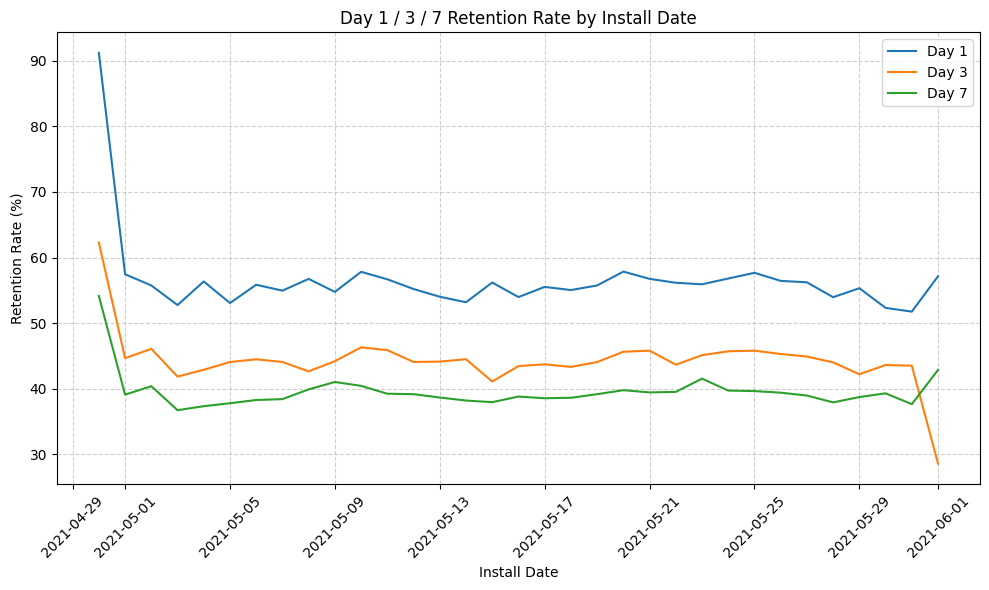

In [ ]:
# Plot Day 1, 3, and 7 retention rates over install dates

plt.figure(figsize=(10, 6))
plt.plot(df_retantion_1['install_date'], df_retantion_1['day1_retention'], label='Day 1')
plt.plot(df_retantion_1['install_date'], df_retantion_1['day3_retention'], label='Day 3')
plt.plot(df_retantion_1['install_date'], df_retantion_1['day7_retention'], label='Day 7')
plt.ylabel("Retention Rate (%)")
plt.xlabel("Install Date")
plt.title("Day 1 / 3 / 7 Retention Rate by Install Date")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Retention Analysis Summary

- **Day 1 retention** consistently hovers between **52–58%**, with some early anomalies possibly due to small sample sizes.
- **Day 3 retention** stabilizes around **43–46%**, indicating a slight drop-off from Day 1.
- **Day 7 retention** holds around **38–41%**, suggesting relatively strong user stickiness beyond the first few days.
- There is **no visible declining trend** across the period, which reflects **stable user engagement patterns** over time.


In [ ]:
query_retantion_2 = """
-- Calculates Day 7 retention rate over time, grouped by platform (iOS vs Android)

WITH installs AS (
  SELECT
    user_id,
    DATE(event_time) AS install_date,
    platform
  FROM case_db.q1_table_install
),

sessions AS (
  SELECT
    user_id,
    DATE(event_time) AS session_date
  FROM case_db.q1_table_session
),

-- Identify users active exactly 7 days after install
retention_base AS (
  SELECT
    i.user_id,
    i.install_date,
    i.platform,
    DATE_DIFF(s.session_date, i.install_date, DAY) AS day_diff
  FROM installs i
  JOIN sessions s ON i.user_id = s.user_id
  WHERE DATE_DIFF(s.session_date, i.install_date, DAY) IN (0, 7)
),

-- Mark users retained on Day 7
retention_flags AS (
  SELECT
    install_date,
    platform,
    user_id,
    MAX(CASE WHEN day_diff = 7 THEN 1 ELSE 0 END) AS day7_retained
  FROM retention_base
  GROUP BY install_date, platform, user_id
)

-- Aggregate Day 7 retention by platform and install date
SELECT
  install_date,
  platform,
  COUNT(user_id) AS installs,
  SUM(day7_retained) AS day7_users,
  ROUND(SAFE_DIVIDE(SUM(day7_retained), COUNT(user_id)) * 100, 2) AS day7_retention
FROM retention_flags
GROUP BY install_date, platform
ORDER BY install_date, platform;

"""

In [ ]:
 df_retantion_2 = conn.query(query_retantion_2).to_dataframe()

In [ ]:
df_retantion_2

,install_date,platform,installs,day7_users,day7_retention
0,2021-04-30,android,158,130,82.28
1,2021-04-30,ios,358,295,82.40
2,2021-05-01,android,3589,1274,35.50
3,2021-05-01,ios,5580,2311,41.42
4,2021-05-02,android,3528,1319,37.39
...,...,...,...,...,...
60,2021-05-30,android,4279,1529,35.73
61,2021-05-30,ios,4534,1934,42.66
62,2021-05-31,android,3533,1275,36.09
63,2021-05-31,ios,2649,1052,39.71


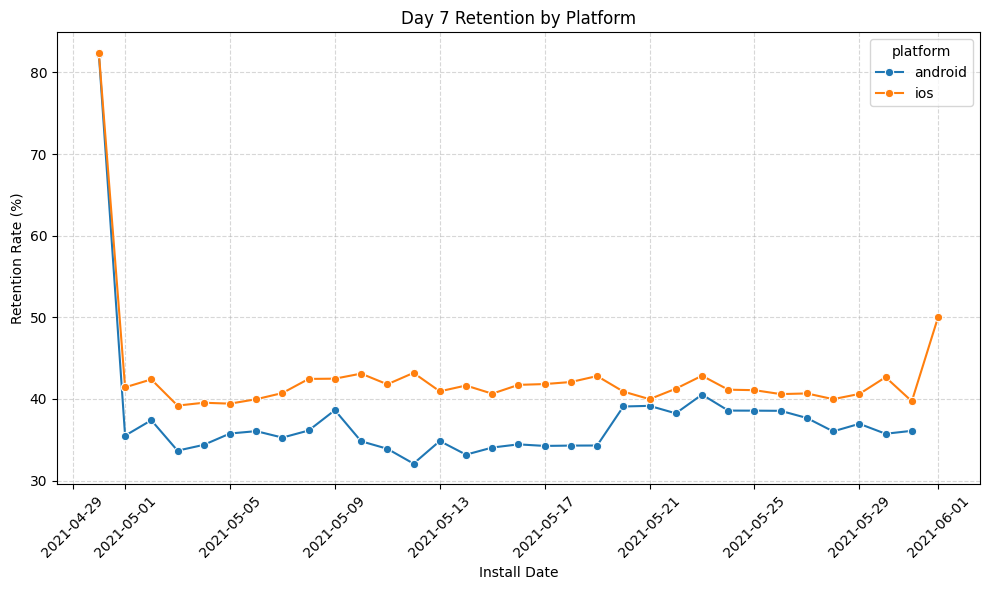

In [ ]:
# Plot Day 7 retention trends by platform

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_retantion_2, x='install_date', y='day7_retention', hue='platform', marker='o')
plt.title("Day 7 Retention by Platform")
plt.ylabel("Retention Rate (%)")
plt.xlabel("Install Date")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Platform Retention Insights – Day 7

- **iOS users** consistently show higher Day 7 retention rates, averaging around **40–43%**, with a few spikes.
- **Android users** exhibit slightly lower retention, fluctuating between **34–39%**.
- Both platforms display **stable retention behavior**, with no sharp declines or growth trends over the observed period.
- iOS may provide a **more loyal user base**, potentially driving better long-term engagement.


In [ ]:
query_retantion_3 = """
-- Calculates Day 7 retention rate grouped by user country and install date

WITH installs AS (
  SELECT
    user_id,
    DATE(event_time) AS install_date,
    country
  FROM case_db.q1_table_install
),

sessions AS (
  SELECT
    user_id,
    DATE(event_time) AS session_date
  FROM case_db.q1_table_session
),

-- Identify sessions occurring on Day 0 or Day 7 after install
retention_base AS (
  SELECT
    i.user_id,
    i.install_date,
    i.country,
    DATE_DIFF(s.session_date, i.install_date, DAY) AS day_diff
  FROM installs i
  JOIN sessions s ON i.user_id = s.user_id
  WHERE DATE_DIFF(s.session_date, i.install_date, DAY) IN (0, 7)
),

-- Flag users retained on Day 7
retention_flags AS (
  SELECT
    install_date,
    country,
    user_id,
    MAX(CASE WHEN day_diff = 7 THEN 1 ELSE 0 END) AS day7_retained
  FROM retention_base
  GROUP BY install_date, country, user_id
)

-- Aggregate and calculate Day 7 retention percentage per country
SELECT
  install_date,
  country,
  COUNT(user_id) AS installs,
  SUM(day7_retained) AS day7_users,
  ROUND(SAFE_DIVIDE(SUM(day7_retained), COUNT(user_id)) * 100, 2) AS day7_retention
FROM retention_flags
GROUP BY install_date, country
ORDER BY install_date, country;

"""

In [ ]:
 df_retantion_3 = conn.query(query_retantion_3).to_dataframe()

In [ ]:
df_retantion_3

,install_date,country,installs,day7_users,day7_retention
0,2021-04-30,Mercury,200,173,86.50
1,2021-04-30,Pluton,108,90,83.33
2,2021-04-30,Saturn,1,1,100.00
3,2021-04-30,Uranus,5,5,100.00
4,2021-04-30,Venus,202,156,77.23
...,...,...,...,...,...
156,2021-05-31,Pluton,2689,1082,40.24
157,2021-05-31,Saturn,311,125,40.19
158,2021-05-31,Uranus,167,52,31.14
159,2021-05-31,Venus,1518,459,30.24


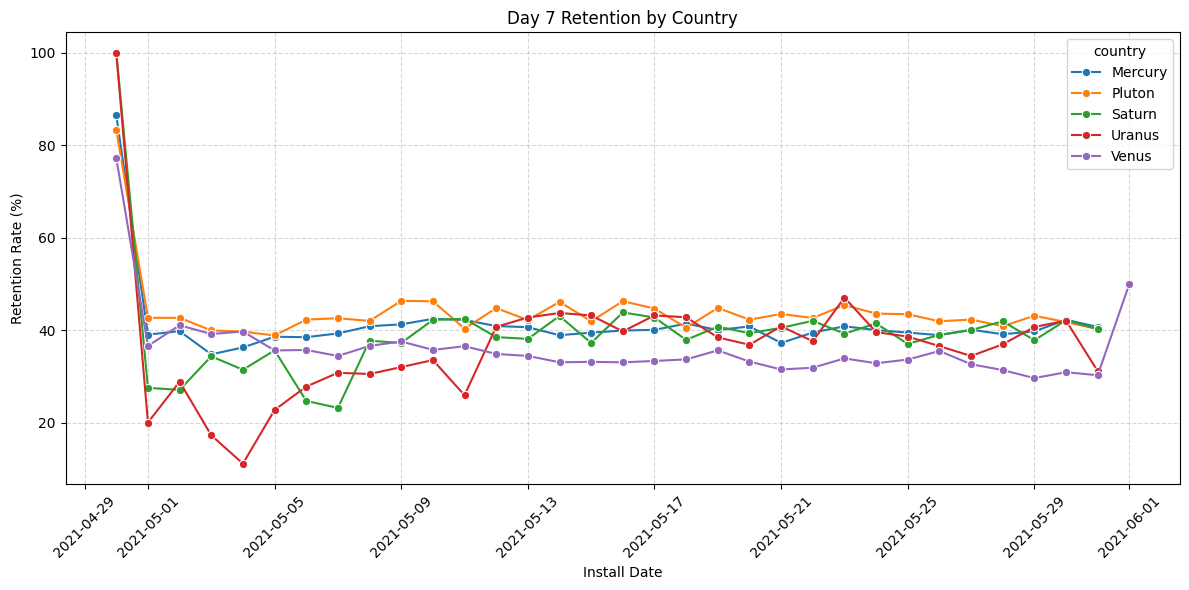

In [ ]:
# Visualize Day 7 retention by country over time

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_retantion_3, x='install_date', y='day7_retention', hue='country', marker='o')
plt.title("Day 7 Retention by Country")
plt.ylabel("Retention Rate (%)")
plt.xlabel("Install Date")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Country-Based Retention Insights – Day 7

- **Pluton** and **Mercury** consistently lead Day 7 retention with rates around **42–45%**, showing strong user engagement.
- **Venus** and **Uranus** trail behind, fluctuating between **30–38%**, indicating weaker long-term user value.
- **Saturn** shows high early variation but later stabilizes around **40%**.
- Overall, country-specific strategies might improve retention performance in lower-performing regions.


In [ ]:
query_retantion_4 = """
-- Calculates Day 7 retention rate grouped by advertising network and install date

WITH installs AS (
  SELECT
    user_id,
    DATE(event_time) AS install_date,
    network
  FROM case_db.q1_table_install
),

sessions AS (
  SELECT
    user_id,
    DATE(event_time) AS session_date
  FROM case_db.q1_table_session
),

-- Filter sessions occurring exactly 0 or 7 days after install
retention_base AS (
  SELECT
    i.user_id,
    i.install_date,
    i.network,
    DATE_DIFF(s.session_date, i.install_date, DAY) AS day_diff
  FROM installs i
  JOIN sessions s ON i.user_id = s.user_id
  WHERE DATE_DIFF(s.session_date, i.install_date, DAY) IN (0, 7)
),

-- Mark users as retained on Day 7
retention_flags AS (
  SELECT
    install_date,
    network,
    user_id,
    MAX(CASE WHEN day_diff = 7 THEN 1 ELSE 0 END) AS day7_retained
  FROM retention_base
  GROUP BY install_date, network, user_id
)

-- Calculate Day 7 retention % per network and date
SELECT
  install_date,
  network,
  COUNT(user_id) AS installs,
  SUM(day7_retained) AS day7_users,
  ROUND(SAFE_DIVIDE(SUM(day7_retained), COUNT(user_id)) * 100, 2) AS day7_retention
FROM retention_flags
GROUP BY install_date, network
ORDER BY install_date, network;

"""

In [ ]:
 df_retantion_4 = conn.query(query_retantion_4).to_dataframe()

In [ ]:
df_retantion_4

,install_date,network,installs,day7_users,day7_retention
0,2021-04-30,Buzz,330,270,81.82
1,2021-04-30,Jessie,15,12,80.00
2,2021-04-30,Organic,93,79,84.95
3,2021-04-30,Sid,19,16,84.21
4,2021-04-30,Woody,59,48,81.36
...,...,...,...,...,...
153,2021-05-31,Buzz,4155,1578,37.98
154,2021-05-31,Organic,1569,611,38.94
155,2021-05-31,Sid,125,49,39.20
156,2021-05-31,Woody,333,89,26.73


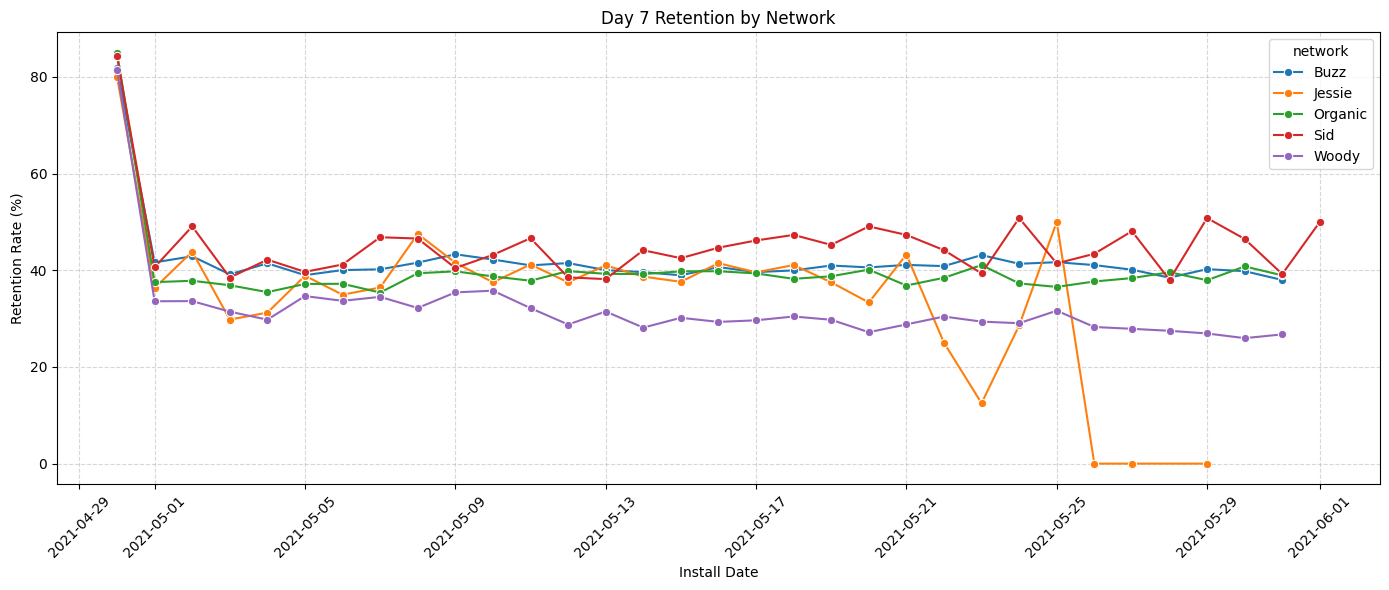

In [ ]:
# Line plot of Day 7 retention trends by network

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_retantion_4, x='install_date', y='day7_retention', hue='network', marker='o')
plt.title("Day 7 Retention by Network")
plt.ylabel("Retention Rate (%)")
plt.xlabel("Install Date")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Network-Based Retention Insights – Day 7

- **Sid** consistently leads with the highest Day 7 retention, often surpassing **45–50%**, suggesting strong user engagement.
- **Buzz** and **Organic** channels maintain stable performance around **38–42%**, indicating reliable retention outcomes.
- **Jessie** shows irregular patterns and even hits **0% retention** on multiple dates — signaling issues like campaign drop-off or data anomalies.
- **Woody** displays a steady decline across time, dropping from ~35% to ~26%, warranting review of creative or targeting strategies.

**Action Point:** Networks like **Sid** can be scaled further, while **Jessie** needs immediate investigation for performance inconsistency.


#Churn

## What is Churn?

**Churn** refers to the percentage of users who stop using an app within a given period. In the context of mobile analytics, **Day 7 churn** measures how many users failed to return between days 1–7 after installing the app.

---

### Why is Churn important?

- **Retention Insight**: Churn is the inverse of retention; high churn means poor user engagement or satisfaction.
- **Product Improvement**: Helps identify friction points or reasons users abandon the app early.
- **Marketing ROI**: Indicates whether acquired users are sticking around long enough to justify their acquisition cost.
- **Lifecycle Optimization**: Guides user journey improvements to reduce early drop-offs.

---

### How is Churn calculated?

Churn is typically calculated as:
Churn Rate = (Number of Users Who Did Not Return) / (Total Users) × 100

For **Day 7 churn**, it’s:
Churn and retention together offer a complete picture of user stickiness and app health.




In [ ]:
query_churn = """
-- Calculates the Day 7 churn rate by install date.
-- A user is considered churned if they do not have any session within 1–7 days after installing.

WITH installs AS (
  SELECT user_id, DATE(event_time) AS install_date
  FROM case_db.q1_table_install
),

sessions AS (
  SELECT user_id, DATE(event_time) AS session_date
  FROM case_db.q1_table_session
),

-- Check if user was active between Day 1 and Day 7 post-install
user_activity_flags AS (
  SELECT
    i.user_id,
    i.install_date,
    MAX(CASE WHEN DATE_DIFF(s.session_date, i.install_date, DAY) BETWEEN 1 AND 7 THEN 1 ELSE 0 END) AS active_within_7d
  FROM installs i
  LEFT JOIN sessions s ON i.user_id = s.user_id
  GROUP BY i.user_id, i.install_date
)

-- Compute churn and retention numbers
SELECT
  install_date,
  COUNT(user_id) AS total_installs,
  SUM(active_within_7d) AS retained_7d,
  COUNT(user_id) - SUM(active_within_7d) AS churned_7d,
  ROUND(SAFE_DIVIDE(COUNT(user_id) - SUM(active_within_7d), COUNT(user_id)) * 100, 2) AS churn_rate_7d
FROM user_activity_flags
GROUP BY install_date
ORDER BY install_date;

"""

In [ ]:
 df_query_churn = conn.query(query_churn).to_dataframe()

In [ ]:
df_query_churn

,install_date,total_installs,retained_7d,churned_7d,churn_rate_7d
0,2021-04-30,1064,828,236,22.18
1,2021-05-01,9177,6430,2747,29.93
2,2021-05-02,8803,6143,2660,30.22
3,2021-05-03,6127,4089,2038,33.26
4,2021-05-04,6467,4411,2056,31.79
5,2021-05-05,6747,4628,2119,31.41
6,2021-05-06,5533,3828,1705,30.82
7,2021-05-07,6033,4166,1867,30.95
8,2021-05-08,7177,4946,2231,31.09
9,2021-05-09,7577,5298,2279,30.08


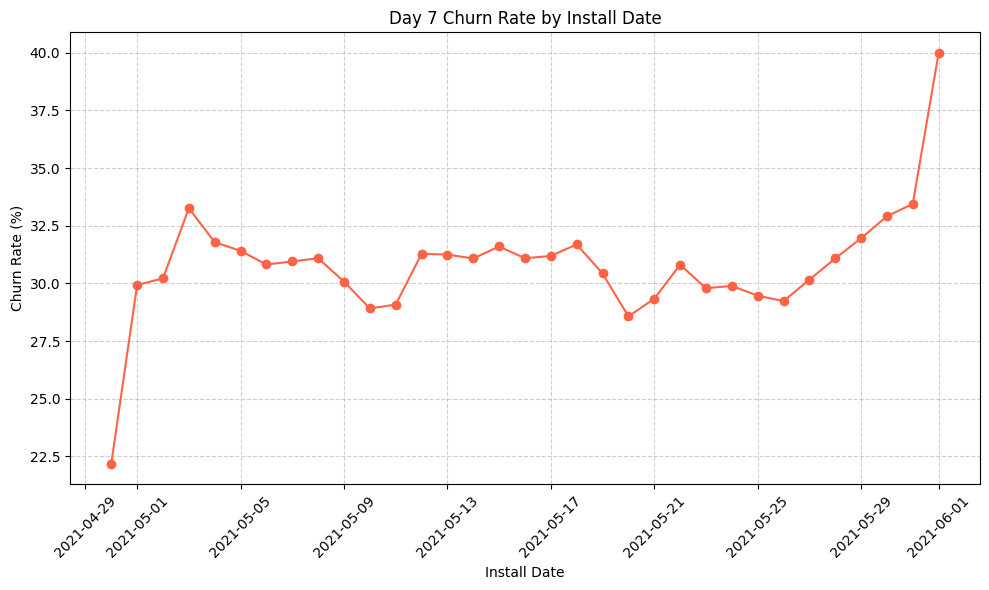

In [ ]:
# Line plot of Day 7 churn rate by install date

plt.figure(figsize=(10, 6))
plt.plot(df_query_churn['install_date'], df_query_churn['churn_rate_7d'], marker='o', color='tomato')
plt.title("Day 7 Churn Rate by Install Date")
plt.ylabel("Churn Rate (%)")
plt.xlabel("Install Date")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Day 7 Churn Rate – Key Observations

- The churn rate remains relatively stable around **30–33%** for most of the period.
- An **anomalous spike** occurs on **June 1**, where churn rate jumps to **40%**, which may indicate:
  - An influx of low-quality traffic,
  - A technical issue,
  - Or an underperforming campaign starting that day.
- The **lowest churn rate** is observed on **April 29**, at around **22%**, suggesting high early retention or loyal user acquisition that day.

**Next Steps:** Investigate campaigns or channels active on June 1 to identify causes of elevated churn. Consistently low churn periods can guide optimization.


# LTV

### What is LTV?

**LTV (Lifetime Value)** is the total revenue a user is expected to generate throughout their lifetime as an app user. It represents the long-term financial value of acquired users.

---

### Why is LTV important?

- **Monetization Strategy**: Helps assess if your monetization approach is effective over time.
- **Marketing Efficiency**: Informs how much you can afford to spend to acquire a user (Cost per Install should be lower than LTV).
- **User Segmentation**: Enables targeting of high-value user cohorts for retention or re-engagement.
- **Business Forecasting**: Provides the foundation for revenue projections and growth planning.

---

### How is LTV calculated?

LTV is computed by summing all revenue associated with each user and averaging across all users who installed the app on a given date:
LTV = Total Revenue from Users / Number of Users

In SQL practice, this typically involves joining install and revenue data, then aggregating per user and install date to derive the **average LTV** per cohort.




In [ ]:
query_ltv = """
-- Computes the average Lifetime Value (LTV) per install date.
-- LTV is the total revenue generated by a user, averaged across all users installed that day.

WITH installs AS (
  SELECT user_id, DATE(event_time) AS install_date
  FROM case_db.q1_table_install
),

revenue AS (
  SELECT user_id, DATE(event_time) AS revenue_date, CAST(revenue AS FLOAT64) AS amount
  FROM case_db.q1_table_revenue
),

-- Aggregate total revenue per user based on install date
ltv_data AS (
  SELECT
    i.install_date,
    i.user_id,
    COALESCE(SUM(r.amount), 0) AS user_ltv
  FROM installs i
  LEFT JOIN revenue r ON i.user_id = r.user_id
  GROUP BY i.install_date, i.user_id
)

-- Compute average LTV per install date
SELECT
  install_date,
  COUNT(user_id) AS total_users,
  ROUND(AVG(user_ltv), 2) AS avg_ltv
FROM ltv_data
GROUP BY install_date
ORDER BY install_date;
"""

In [ ]:
 df_query_ltv = conn.query(query_ltv).to_dataframe()

In [ ]:
df_query_ltv

,install_date,total_users,avg_ltv
0,2021-04-30,1064,2.20
1,2021-05-01,9177,2.85
2,2021-05-02,8803,3.10
3,2021-05-03,6127,2.42
4,2021-05-04,6467,2.56
5,2021-05-05,6747,1.97
6,2021-05-06,5533,3.16
7,2021-05-07,6033,2.36
8,2021-05-08,7177,2.80
9,2021-05-09,7577,2.37


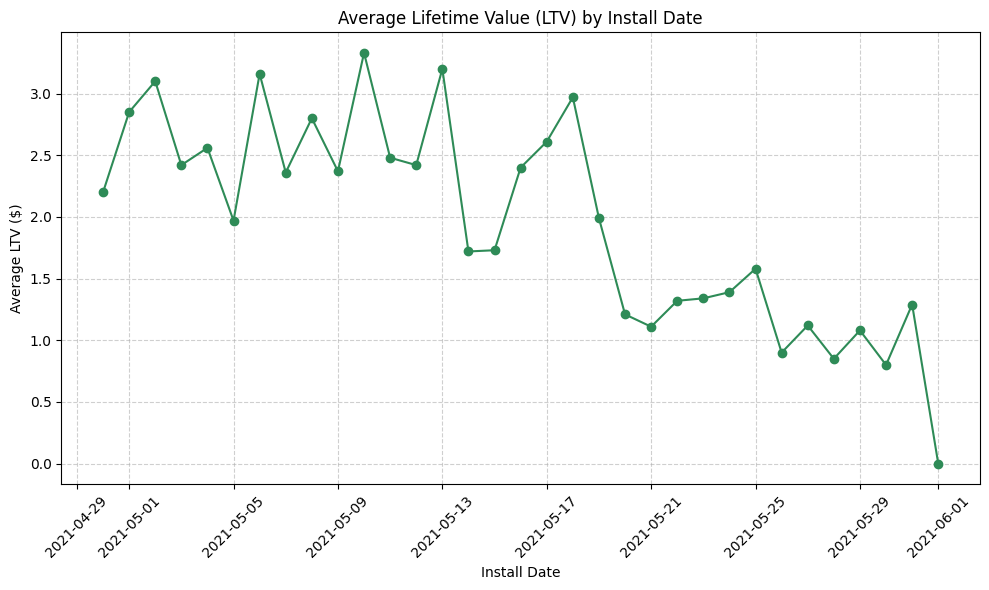

In [ ]:
# Line chart of average LTV by install date

plt.figure(figsize=(10, 6))
plt.plot(df_query_ltv['install_date'], df_query_ltv['avg_ltv'], marker='o', color='seagreen')
plt.title("Average Lifetime Value (LTV) by Install Date")
plt.ylabel("Average LTV ($)")
plt.xlabel("Install Date")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Average LTV by Install Date – Summary Insights

- Average LTV values from **April 29 to May 20** mostly range between **$2.0 and $3.3**, indicating high monetization efficiency.
- A **noticeable decline** starts around **May 21**, with LTV values dropping below **$1.5** and reaching **$0.0** on **June 1**.
- This trend may indicate a **quality drop in acquired users** or an issue affecting monetization during the second half of the period.

**Next Steps:** Review user acquisition campaigns or changes in monetization starting mid-May. Investigate the cause of the revenue collapse on June 1.
